# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [2]:
!nvidia-smi

Thu May 19 01:42:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

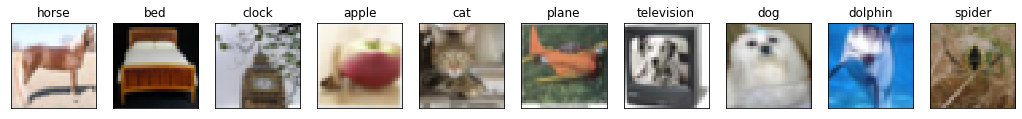

In [4]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

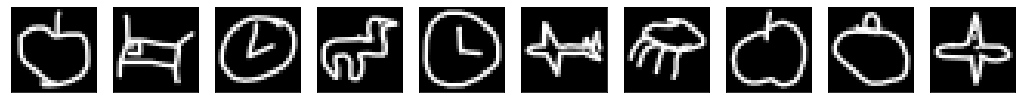

In [5]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


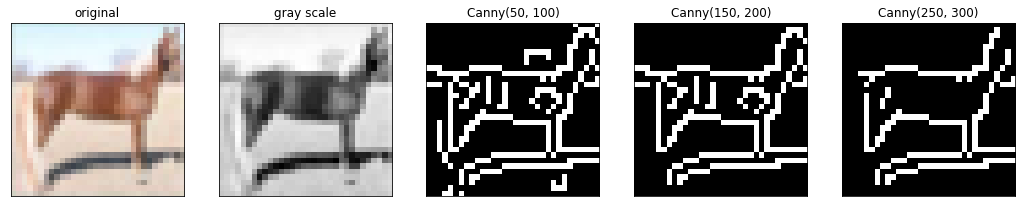

In [6]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [42]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [43]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
optimizer_F = optim.AdamW(feature_extractor.parameters(), lr=lr)
optimizer_C = optim.AdamW(label_predictor.parameters(), lr=lr)
optimizer_D = optim.AdamW(domain_classifier.parameters(), lr=lr)

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [44]:
from tqdm import tqdm
import math

In [47]:
num_epoch = 1000
def lamb_scheduler(epoch, num_epoch=num_epoch):
    return 2.5/(1+ math.exp(-10*((epoch+1)/num_epoch)))-1

In [48]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    total_D_hit, total_D_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Calculate train D accuracy
        d_rate = nn.Sigmoid()(domain_logits)
        total_D_hit += (d_rate[:source_data.shape[0]] > 0.5).sum().item()
        total_D_hit += (d_rate[source_data.shape[0]:] < 0.5).sum().item()
        total_D_num += d_rate.shape[0]

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), total_D_hit / total_D_num, running_F_loss / (i+1), total_hit / total_num

for epoch in tqdm(range(num_epoch)):
    train_D_loss, train_D_acc, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb_scheduler(epoch))

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, D_acc: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_D_acc, train_F_loss, train_acc))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:08<2:26:54,  8.82s/it]

epoch   0: train D loss: 0.7811, D_acc: 0.5343, train F loss: 2.1305, acc 0.0974


  0%|          | 2/1000 [00:17<2:28:21,  8.92s/it]

epoch   1: train D loss: 0.6855, D_acc: 0.5785, train F loss: 1.9963, acc 0.1506


  0%|          | 3/1000 [00:26<2:28:36,  8.94s/it]

epoch   2: train D loss: 0.6784, D_acc: 0.5535, train F loss: 1.8654, acc 0.2322


  0%|          | 4/1000 [00:35<2:28:42,  8.96s/it]

epoch   3: train D loss: 0.6924, D_acc: 0.5367, train F loss: 1.7172, acc 0.2840


  0%|          | 5/1000 [00:44<2:28:02,  8.93s/it]

epoch   4: train D loss: 0.6795, D_acc: 0.5656, train F loss: 1.6357, acc 0.3048


  1%|          | 6/1000 [00:53<2:27:24,  8.90s/it]

epoch   5: train D loss: 0.6764, D_acc: 0.5747, train F loss: 1.5484, acc 0.3542


  1%|          | 7/1000 [01:02<2:27:18,  8.90s/it]

epoch   6: train D loss: 0.6680, D_acc: 0.5845, train F loss: 1.4769, acc 0.3884


  1%|          | 8/1000 [01:11<2:27:13,  8.90s/it]

epoch   7: train D loss: 0.6737, D_acc: 0.5776, train F loss: 1.3828, acc 0.4304


  1%|          | 9/1000 [01:20<2:26:47,  8.89s/it]

epoch   8: train D loss: 0.6765, D_acc: 0.5637, train F loss: 1.3258, acc 0.4446


  1%|          | 10/1000 [01:29<2:26:43,  8.89s/it]

epoch   9: train D loss: 0.6689, D_acc: 0.5854, train F loss: 1.2482, acc 0.4804


  1%|          | 11/1000 [01:37<2:26:22,  8.88s/it]

epoch  10: train D loss: 0.6735, D_acc: 0.5698, train F loss: 1.2222, acc 0.4844


  1%|          | 12/1000 [01:46<2:26:36,  8.90s/it]

epoch  11: train D loss: 0.6692, D_acc: 0.5880, train F loss: 1.2007, acc 0.5044


  1%|▏         | 13/1000 [01:55<2:26:11,  8.89s/it]

epoch  12: train D loss: 0.6795, D_acc: 0.5640, train F loss: 1.1458, acc 0.5170


  1%|▏         | 14/1000 [02:04<2:25:57,  8.88s/it]

epoch  13: train D loss: 0.6718, D_acc: 0.5848, train F loss: 1.1070, acc 0.5404


  2%|▏         | 15/1000 [02:13<2:25:41,  8.87s/it]

epoch  14: train D loss: 0.6693, D_acc: 0.5802, train F loss: 1.0964, acc 0.5374


  2%|▏         | 16/1000 [02:22<2:25:42,  8.88s/it]

epoch  15: train D loss: 0.6726, D_acc: 0.5805, train F loss: 1.0418, acc 0.5538


  2%|▏         | 17/1000 [02:31<2:25:26,  8.88s/it]

epoch  16: train D loss: 0.6766, D_acc: 0.5689, train F loss: 1.0361, acc 0.5648


  2%|▏         | 18/1000 [02:40<2:25:46,  8.91s/it]

epoch  17: train D loss: 0.6770, D_acc: 0.5640, train F loss: 0.9898, acc 0.5776


  2%|▏         | 19/1000 [02:49<2:25:43,  8.91s/it]

epoch  18: train D loss: 0.6769, D_acc: 0.5726, train F loss: 0.9831, acc 0.5720


  2%|▏         | 20/1000 [02:58<2:26:07,  8.95s/it]

epoch  19: train D loss: 0.6791, D_acc: 0.5612, train F loss: 0.9373, acc 0.5862


  2%|▏         | 21/1000 [03:07<2:25:52,  8.94s/it]

epoch  20: train D loss: 0.6810, D_acc: 0.5541, train F loss: 0.9129, acc 0.5968


  2%|▏         | 22/1000 [03:15<2:25:24,  8.92s/it]

epoch  21: train D loss: 0.6781, D_acc: 0.5672, train F loss: 0.8758, acc 0.6132


  2%|▏         | 23/1000 [03:24<2:25:02,  8.91s/it]

epoch  22: train D loss: 0.6777, D_acc: 0.5706, train F loss: 0.8601, acc 0.6170


  2%|▏         | 24/1000 [03:33<2:24:59,  8.91s/it]

epoch  23: train D loss: 0.6821, D_acc: 0.5561, train F loss: 0.8292, acc 0.6222


  2%|▎         | 25/1000 [03:42<2:24:56,  8.92s/it]

epoch  24: train D loss: 0.6822, D_acc: 0.5618, train F loss: 0.7942, acc 0.6350


  3%|▎         | 26/1000 [03:51<2:24:32,  8.90s/it]

epoch  25: train D loss: 0.6812, D_acc: 0.5640, train F loss: 0.7906, acc 0.6372


  3%|▎         | 27/1000 [04:00<2:24:23,  8.90s/it]

epoch  26: train D loss: 0.6824, D_acc: 0.5579, train F loss: 0.7551, acc 0.6492


  3%|▎         | 28/1000 [04:09<2:24:23,  8.91s/it]

epoch  27: train D loss: 0.6828, D_acc: 0.5531, train F loss: 0.7399, acc 0.6528


  3%|▎         | 29/1000 [04:18<2:24:00,  8.90s/it]

epoch  28: train D loss: 0.6853, D_acc: 0.5540, train F loss: 0.7032, acc 0.6550


  3%|▎         | 30/1000 [04:27<2:23:47,  8.89s/it]

epoch  29: train D loss: 0.6844, D_acc: 0.5485, train F loss: 0.6948, acc 0.6652


  3%|▎         | 31/1000 [04:36<2:23:47,  8.90s/it]

epoch  30: train D loss: 0.6858, D_acc: 0.5429, train F loss: 0.6449, acc 0.6790


  3%|▎         | 32/1000 [04:44<2:23:26,  8.89s/it]

epoch  31: train D loss: 0.6840, D_acc: 0.5485, train F loss: 0.6234, acc 0.6756


  3%|▎         | 33/1000 [04:53<2:23:15,  8.89s/it]

epoch  32: train D loss: 0.6846, D_acc: 0.5421, train F loss: 0.5867, acc 0.6862


  3%|▎         | 34/1000 [05:02<2:23:02,  8.88s/it]

epoch  33: train D loss: 0.6851, D_acc: 0.5439, train F loss: 0.5826, acc 0.6894


  4%|▎         | 35/1000 [05:11<2:22:52,  8.88s/it]

epoch  34: train D loss: 0.6835, D_acc: 0.5502, train F loss: 0.5636, acc 0.6958


  4%|▎         | 36/1000 [05:20<2:22:56,  8.90s/it]

epoch  35: train D loss: 0.6868, D_acc: 0.5468, train F loss: 0.5155, acc 0.7148


  4%|▎         | 37/1000 [05:29<2:23:26,  8.94s/it]

epoch  36: train D loss: 0.6839, D_acc: 0.5527, train F loss: 0.5034, acc 0.7162


  4%|▍         | 38/1000 [05:38<2:23:35,  8.96s/it]

epoch  37: train D loss: 0.6870, D_acc: 0.5407, train F loss: 0.4781, acc 0.7272


  4%|▍         | 39/1000 [05:47<2:23:13,  8.94s/it]

epoch  38: train D loss: 0.6841, D_acc: 0.5553, train F loss: 0.4743, acc 0.7298


  4%|▍         | 40/1000 [05:56<2:22:44,  8.92s/it]

epoch  39: train D loss: 0.6861, D_acc: 0.5475, train F loss: 0.4275, acc 0.7454


  4%|▍         | 41/1000 [06:05<2:22:13,  8.90s/it]

epoch  40: train D loss: 0.6867, D_acc: 0.5404, train F loss: 0.3871, acc 0.7444


  4%|▍         | 42/1000 [06:14<2:22:07,  8.90s/it]

epoch  41: train D loss: 0.6870, D_acc: 0.5480, train F loss: 0.3712, acc 0.7574


  4%|▍         | 43/1000 [06:22<2:22:13,  8.92s/it]

epoch  42: train D loss: 0.6851, D_acc: 0.5524, train F loss: 0.3548, acc 0.7632


  4%|▍         | 44/1000 [06:31<2:22:11,  8.92s/it]

epoch  43: train D loss: 0.6877, D_acc: 0.5489, train F loss: 0.3323, acc 0.7682


  4%|▍         | 45/1000 [06:40<2:21:58,  8.92s/it]

epoch  44: train D loss: 0.6838, D_acc: 0.5560, train F loss: 0.3195, acc 0.7622


  5%|▍         | 46/1000 [06:49<2:21:28,  8.90s/it]

epoch  45: train D loss: 0.6876, D_acc: 0.5408, train F loss: 0.2755, acc 0.7882


  5%|▍         | 47/1000 [06:58<2:21:09,  8.89s/it]

epoch  46: train D loss: 0.6865, D_acc: 0.5483, train F loss: 0.2497, acc 0.7986


  5%|▍         | 48/1000 [07:07<2:21:14,  8.90s/it]

epoch  47: train D loss: 0.6876, D_acc: 0.5428, train F loss: 0.2428, acc 0.7980


  5%|▍         | 49/1000 [07:16<2:21:51,  8.95s/it]

epoch  48: train D loss: 0.6852, D_acc: 0.5537, train F loss: 0.2241, acc 0.7976


  5%|▌         | 50/1000 [07:25<2:21:18,  8.92s/it]

epoch  49: train D loss: 0.6866, D_acc: 0.5453, train F loss: 0.1795, acc 0.8100


  5%|▌         | 51/1000 [07:34<2:20:59,  8.91s/it]

epoch  50: train D loss: 0.6867, D_acc: 0.5461, train F loss: 0.1714, acc 0.8130


  5%|▌         | 52/1000 [07:43<2:20:48,  8.91s/it]

epoch  51: train D loss: 0.6853, D_acc: 0.5575, train F loss: 0.1326, acc 0.8264


  5%|▌         | 53/1000 [07:52<2:20:57,  8.93s/it]

epoch  52: train D loss: 0.6845, D_acc: 0.5510, train F loss: 0.1360, acc 0.8232


  5%|▌         | 54/1000 [08:01<2:20:43,  8.93s/it]

epoch  53: train D loss: 0.6872, D_acc: 0.5487, train F loss: 0.1313, acc 0.8270


  6%|▌         | 55/1000 [08:10<2:20:26,  8.92s/it]

epoch  54: train D loss: 0.6841, D_acc: 0.5489, train F loss: 0.0989, acc 0.8316


  6%|▌         | 56/1000 [08:18<2:20:01,  8.90s/it]

epoch  55: train D loss: 0.6859, D_acc: 0.5537, train F loss: 0.0817, acc 0.8402


  6%|▌         | 57/1000 [08:27<2:19:45,  8.89s/it]

epoch  56: train D loss: 0.6852, D_acc: 0.5528, train F loss: 0.0749, acc 0.8420


  6%|▌         | 58/1000 [08:36<2:19:50,  8.91s/it]

epoch  57: train D loss: 0.6855, D_acc: 0.5500, train F loss: 0.0636, acc 0.8432


  6%|▌         | 59/1000 [08:45<2:19:44,  8.91s/it]

epoch  58: train D loss: 0.6860, D_acc: 0.5496, train F loss: 0.0118, acc 0.8528


  6%|▌         | 60/1000 [08:54<2:19:51,  8.93s/it]

epoch  59: train D loss: 0.6811, D_acc: 0.5608, train F loss: 0.0098, acc 0.8582


  6%|▌         | 61/1000 [09:03<2:19:18,  8.90s/it]

epoch  60: train D loss: 0.6847, D_acc: 0.5561, train F loss: 0.0149, acc 0.8562


  6%|▌         | 62/1000 [09:12<2:19:14,  8.91s/it]

epoch  61: train D loss: 0.6831, D_acc: 0.5552, train F loss: -0.0151, acc 0.8634


  6%|▋         | 63/1000 [09:21<2:19:10,  8.91s/it]

epoch  62: train D loss: 0.6887, D_acc: 0.5385, train F loss: -0.0145, acc 0.8640


  6%|▋         | 64/1000 [09:30<2:19:25,  8.94s/it]

epoch  63: train D loss: 0.6855, D_acc: 0.5510, train F loss: -0.0519, acc 0.8788


  6%|▋         | 65/1000 [09:39<2:19:01,  8.92s/it]

epoch  64: train D loss: 0.6811, D_acc: 0.5615, train F loss: -0.0628, acc 0.8788


  7%|▋         | 66/1000 [09:48<2:19:13,  8.94s/it]

epoch  65: train D loss: 0.6866, D_acc: 0.5476, train F loss: -0.0757, acc 0.8786


  7%|▋         | 67/1000 [09:56<2:18:37,  8.91s/it]

epoch  66: train D loss: 0.6844, D_acc: 0.5540, train F loss: -0.0749, acc 0.8786


  7%|▋         | 68/1000 [10:05<2:17:58,  8.88s/it]

epoch  67: train D loss: 0.6862, D_acc: 0.5521, train F loss: -0.1017, acc 0.8838


  7%|▋         | 69/1000 [10:14<2:17:48,  8.88s/it]

epoch  68: train D loss: 0.6859, D_acc: 0.5533, train F loss: -0.1197, acc 0.8934


  7%|▋         | 70/1000 [10:23<2:17:49,  8.89s/it]

epoch  69: train D loss: 0.6835, D_acc: 0.5626, train F loss: -0.1386, acc 0.8970


  7%|▋         | 71/1000 [10:32<2:17:52,  8.90s/it]

epoch  70: train D loss: 0.6875, D_acc: 0.5437, train F loss: -0.1570, acc 0.8996


  7%|▋         | 72/1000 [10:41<2:18:16,  8.94s/it]

epoch  71: train D loss: 0.6816, D_acc: 0.5673, train F loss: -0.1525, acc 0.9026


  7%|▋         | 73/1000 [10:50<2:18:35,  8.97s/it]

epoch  72: train D loss: 0.6846, D_acc: 0.5532, train F loss: -0.1673, acc 0.9000


  7%|▋         | 74/1000 [10:59<2:20:29,  9.10s/it]

epoch  73: train D loss: 0.6843, D_acc: 0.5551, train F loss: -0.1667, acc 0.8984


  8%|▊         | 75/1000 [11:08<2:19:50,  9.07s/it]

epoch  74: train D loss: 0.6849, D_acc: 0.5538, train F loss: -0.1909, acc 0.9080


  8%|▊         | 76/1000 [11:17<2:18:57,  9.02s/it]

epoch  75: train D loss: 0.6843, D_acc: 0.5477, train F loss: -0.1735, acc 0.8978


  8%|▊         | 77/1000 [11:26<2:18:13,  8.99s/it]

epoch  76: train D loss: 0.6842, D_acc: 0.5532, train F loss: -0.1959, acc 0.9042


  8%|▊         | 78/1000 [11:35<2:17:46,  8.97s/it]

epoch  77: train D loss: 0.6824, D_acc: 0.5592, train F loss: -0.2085, acc 0.9062


  8%|▊         | 79/1000 [11:44<2:17:15,  8.94s/it]

epoch  78: train D loss: 0.6847, D_acc: 0.5493, train F loss: -0.2394, acc 0.9204


  8%|▊         | 80/1000 [11:53<2:16:53,  8.93s/it]

epoch  79: train D loss: 0.6869, D_acc: 0.5462, train F loss: -0.2377, acc 0.9130


  8%|▊         | 81/1000 [12:02<2:16:40,  8.92s/it]

epoch  80: train D loss: 0.6830, D_acc: 0.5532, train F loss: -0.2408, acc 0.9148


  8%|▊         | 82/1000 [12:11<2:16:21,  8.91s/it]

epoch  81: train D loss: 0.6817, D_acc: 0.5569, train F loss: -0.2375, acc 0.9112


  8%|▊         | 83/1000 [12:20<2:16:10,  8.91s/it]

epoch  82: train D loss: 0.6856, D_acc: 0.5511, train F loss: -0.2824, acc 0.9230


  8%|▊         | 84/1000 [12:29<2:16:01,  8.91s/it]

epoch  83: train D loss: 0.6838, D_acc: 0.5582, train F loss: -0.2432, acc 0.9138


  8%|▊         | 85/1000 [12:38<2:15:51,  8.91s/it]

epoch  84: train D loss: 0.6843, D_acc: 0.5562, train F loss: -0.2622, acc 0.9166


  9%|▊         | 86/1000 [12:46<2:15:21,  8.89s/it]

epoch  85: train D loss: 0.6828, D_acc: 0.5585, train F loss: -0.2852, acc 0.9264


  9%|▊         | 87/1000 [12:55<2:15:23,  8.90s/it]

epoch  86: train D loss: 0.6871, D_acc: 0.5498, train F loss: -0.2815, acc 0.9238


  9%|▉         | 88/1000 [13:04<2:15:26,  8.91s/it]

epoch  87: train D loss: 0.6820, D_acc: 0.5624, train F loss: -0.2993, acc 0.9292


  9%|▉         | 89/1000 [13:13<2:15:01,  8.89s/it]

epoch  88: train D loss: 0.6844, D_acc: 0.5517, train F loss: -0.3056, acc 0.9284


  9%|▉         | 90/1000 [13:22<2:14:48,  8.89s/it]

epoch  89: train D loss: 0.6806, D_acc: 0.5691, train F loss: -0.3037, acc 0.9270


  9%|▉         | 91/1000 [13:31<2:14:42,  8.89s/it]

epoch  90: train D loss: 0.6812, D_acc: 0.5626, train F loss: -0.3030, acc 0.9262


  9%|▉         | 92/1000 [13:40<2:14:47,  8.91s/it]

epoch  91: train D loss: 0.6836, D_acc: 0.5571, train F loss: -0.3267, acc 0.9322


  9%|▉         | 93/1000 [13:49<2:14:51,  8.92s/it]

epoch  92: train D loss: 0.6796, D_acc: 0.5641, train F loss: -0.3297, acc 0.9348


  9%|▉         | 94/1000 [13:58<2:14:47,  8.93s/it]

epoch  93: train D loss: 0.6851, D_acc: 0.5523, train F loss: -0.3296, acc 0.9322


 10%|▉         | 95/1000 [14:07<2:14:18,  8.90s/it]

epoch  94: train D loss: 0.6825, D_acc: 0.5600, train F loss: -0.3415, acc 0.9328


 10%|▉         | 96/1000 [14:15<2:14:04,  8.90s/it]

epoch  95: train D loss: 0.6816, D_acc: 0.5582, train F loss: -0.3485, acc 0.9364


 10%|▉         | 97/1000 [14:24<2:14:02,  8.91s/it]

epoch  96: train D loss: 0.6831, D_acc: 0.5536, train F loss: -0.3568, acc 0.9318


 10%|▉         | 98/1000 [14:33<2:14:18,  8.93s/it]

epoch  97: train D loss: 0.6825, D_acc: 0.5530, train F loss: -0.3651, acc 0.9380


 10%|▉         | 99/1000 [14:42<2:14:07,  8.93s/it]

epoch  98: train D loss: 0.6854, D_acc: 0.5470, train F loss: -0.3659, acc 0.9384


 10%|█         | 100/1000 [14:51<2:13:59,  8.93s/it]

epoch  99: train D loss: 0.6816, D_acc: 0.5616, train F loss: -0.3654, acc 0.9358


 10%|█         | 101/1000 [15:00<2:13:43,  8.92s/it]

epoch 100: train D loss: 0.6775, D_acc: 0.5703, train F loss: -0.4056, acc 0.9508


 10%|█         | 102/1000 [15:09<2:13:12,  8.90s/it]

epoch 101: train D loss: 0.6869, D_acc: 0.5451, train F loss: -0.3798, acc 0.9356


 10%|█         | 103/1000 [15:18<2:13:24,  8.92s/it]

epoch 102: train D loss: 0.6841, D_acc: 0.5572, train F loss: -0.3714, acc 0.9350


 10%|█         | 104/1000 [15:27<2:12:46,  8.89s/it]

epoch 103: train D loss: 0.6838, D_acc: 0.5515, train F loss: -0.3852, acc 0.9360


 10%|█         | 105/1000 [15:36<2:12:45,  8.90s/it]

epoch 104: train D loss: 0.6779, D_acc: 0.5690, train F loss: -0.4140, acc 0.9478


 11%|█         | 106/1000 [15:45<2:12:44,  8.91s/it]

epoch 105: train D loss: 0.6786, D_acc: 0.5705, train F loss: -0.3984, acc 0.9442


 11%|█         | 107/1000 [15:54<2:12:49,  8.92s/it]

epoch 106: train D loss: 0.6796, D_acc: 0.5647, train F loss: -0.4160, acc 0.9458


 11%|█         | 108/1000 [16:03<2:12:53,  8.94s/it]

epoch 107: train D loss: 0.6826, D_acc: 0.5532, train F loss: -0.4352, acc 0.9486


 11%|█         | 109/1000 [16:11<2:12:40,  8.93s/it]

epoch 108: train D loss: 0.6851, D_acc: 0.5404, train F loss: -0.4192, acc 0.9440


 11%|█         | 110/1000 [16:20<2:12:31,  8.93s/it]

epoch 109: train D loss: 0.6792, D_acc: 0.5703, train F loss: -0.4278, acc 0.9466


 11%|█         | 111/1000 [16:29<2:12:27,  8.94s/it]

epoch 110: train D loss: 0.6845, D_acc: 0.5513, train F loss: -0.4242, acc 0.9460


 11%|█         | 112/1000 [16:38<2:12:13,  8.93s/it]

epoch 111: train D loss: 0.6805, D_acc: 0.5611, train F loss: -0.4251, acc 0.9450


 11%|█▏        | 113/1000 [16:47<2:11:45,  8.91s/it]

epoch 112: train D loss: 0.6847, D_acc: 0.5507, train F loss: -0.4191, acc 0.9416


 11%|█▏        | 114/1000 [16:56<2:11:42,  8.92s/it]

epoch 113: train D loss: 0.6841, D_acc: 0.5468, train F loss: -0.4283, acc 0.9412


 12%|█▏        | 115/1000 [17:05<2:11:33,  8.92s/it]

epoch 114: train D loss: 0.6827, D_acc: 0.5653, train F loss: -0.4560, acc 0.9498


 12%|█▏        | 116/1000 [17:14<2:11:24,  8.92s/it]

epoch 115: train D loss: 0.6847, D_acc: 0.5474, train F loss: -0.4655, acc 0.9522


 12%|█▏        | 117/1000 [17:23<2:11:29,  8.94s/it]

epoch 116: train D loss: 0.6821, D_acc: 0.5600, train F loss: -0.4518, acc 0.9466


 12%|█▏        | 118/1000 [17:32<2:11:21,  8.94s/it]

epoch 117: train D loss: 0.6788, D_acc: 0.5666, train F loss: -0.4712, acc 0.9546


 12%|█▏        | 119/1000 [17:41<2:11:17,  8.94s/it]

epoch 118: train D loss: 0.6826, D_acc: 0.5554, train F loss: -0.4482, acc 0.9458


 12%|█▏        | 120/1000 [17:50<2:11:06,  8.94s/it]

epoch 119: train D loss: 0.6799, D_acc: 0.5614, train F loss: -0.4805, acc 0.9532


 12%|█▏        | 121/1000 [17:59<2:10:39,  8.92s/it]

epoch 120: train D loss: 0.6828, D_acc: 0.5488, train F loss: -0.4848, acc 0.9522


 12%|█▏        | 122/1000 [18:07<2:10:18,  8.91s/it]

epoch 121: train D loss: 0.6811, D_acc: 0.5619, train F loss: -0.4844, acc 0.9492


 12%|█▏        | 123/1000 [18:16<2:09:46,  8.88s/it]

epoch 122: train D loss: 0.6813, D_acc: 0.5524, train F loss: -0.4872, acc 0.9510


 12%|█▏        | 124/1000 [18:25<2:09:43,  8.89s/it]

epoch 123: train D loss: 0.6815, D_acc: 0.5637, train F loss: -0.4955, acc 0.9534


 12%|█▎        | 125/1000 [18:34<2:09:44,  8.90s/it]

epoch 124: train D loss: 0.6831, D_acc: 0.5577, train F loss: -0.4971, acc 0.9520


 13%|█▎        | 126/1000 [18:43<2:09:36,  8.90s/it]

epoch 125: train D loss: 0.6808, D_acc: 0.5496, train F loss: -0.5095, acc 0.9576


 13%|█▎        | 127/1000 [18:52<2:09:22,  8.89s/it]

epoch 126: train D loss: 0.6832, D_acc: 0.5575, train F loss: -0.5010, acc 0.9546


 13%|█▎        | 128/1000 [19:01<2:09:36,  8.92s/it]

epoch 127: train D loss: 0.6842, D_acc: 0.5535, train F loss: -0.5107, acc 0.9542


 13%|█▎        | 129/1000 [19:10<2:09:21,  8.91s/it]

epoch 128: train D loss: 0.6839, D_acc: 0.5453, train F loss: -0.5106, acc 0.9542


 13%|█▎        | 130/1000 [19:19<2:09:25,  8.93s/it]

epoch 129: train D loss: 0.6840, D_acc: 0.5437, train F loss: -0.5172, acc 0.9508


 13%|█▎        | 131/1000 [19:28<2:09:00,  8.91s/it]

epoch 130: train D loss: 0.6807, D_acc: 0.5555, train F loss: -0.5210, acc 0.9572


 13%|█▎        | 132/1000 [19:36<2:08:41,  8.90s/it]

epoch 131: train D loss: 0.6794, D_acc: 0.5593, train F loss: -0.5239, acc 0.9538


 13%|█▎        | 133/1000 [19:45<2:08:50,  8.92s/it]

epoch 132: train D loss: 0.6819, D_acc: 0.5640, train F loss: -0.5174, acc 0.9518


 13%|█▎        | 134/1000 [19:54<2:08:28,  8.90s/it]

epoch 133: train D loss: 0.6807, D_acc: 0.5679, train F loss: -0.5240, acc 0.9554


 14%|█▎        | 135/1000 [20:03<2:08:15,  8.90s/it]

epoch 134: train D loss: 0.6823, D_acc: 0.5551, train F loss: -0.5423, acc 0.9606


 14%|█▎        | 136/1000 [20:12<2:08:04,  8.89s/it]

epoch 135: train D loss: 0.6821, D_acc: 0.5594, train F loss: -0.5458, acc 0.9574


 14%|█▎        | 137/1000 [20:21<2:08:05,  8.91s/it]

epoch 136: train D loss: 0.6786, D_acc: 0.5706, train F loss: -0.5492, acc 0.9580


 14%|█▍        | 138/1000 [20:30<2:07:50,  8.90s/it]

epoch 137: train D loss: 0.6821, D_acc: 0.5561, train F loss: -0.5598, acc 0.9622


 14%|█▍        | 139/1000 [20:39<2:08:04,  8.92s/it]

epoch 138: train D loss: 0.6867, D_acc: 0.5421, train F loss: -0.5399, acc 0.9506


 14%|█▍        | 140/1000 [20:48<2:07:46,  8.91s/it]

epoch 139: train D loss: 0.6828, D_acc: 0.5555, train F loss: -0.5302, acc 0.9536


 14%|█▍        | 141/1000 [20:57<2:07:21,  8.90s/it]

epoch 140: train D loss: 0.6829, D_acc: 0.5555, train F loss: -0.5801, acc 0.9632


 14%|█▍        | 142/1000 [21:05<2:07:20,  8.91s/it]

epoch 141: train D loss: 0.6851, D_acc: 0.5405, train F loss: -0.5639, acc 0.9584


 14%|█▍        | 143/1000 [21:14<2:07:01,  8.89s/it]

epoch 142: train D loss: 0.6801, D_acc: 0.5608, train F loss: -0.5448, acc 0.9530


 14%|█▍        | 144/1000 [21:23<2:06:46,  8.89s/it]

epoch 143: train D loss: 0.6816, D_acc: 0.5603, train F loss: -0.5413, acc 0.9498


 14%|█▍        | 145/1000 [21:32<2:06:55,  8.91s/it]

epoch 144: train D loss: 0.6822, D_acc: 0.5550, train F loss: -0.5876, acc 0.9640


 15%|█▍        | 146/1000 [21:41<2:06:46,  8.91s/it]

epoch 145: train D loss: 0.6831, D_acc: 0.5539, train F loss: -0.5743, acc 0.9552


 15%|█▍        | 147/1000 [21:50<2:06:30,  8.90s/it]

epoch 146: train D loss: 0.6861, D_acc: 0.5487, train F loss: -0.5838, acc 0.9590


 15%|█▍        | 148/1000 [21:59<2:06:14,  8.89s/it]

epoch 147: train D loss: 0.6850, D_acc: 0.5481, train F loss: -0.6028, acc 0.9662


 15%|█▍        | 149/1000 [22:08<2:05:58,  8.88s/it]

epoch 148: train D loss: 0.6813, D_acc: 0.5537, train F loss: -0.5647, acc 0.9568


 15%|█▌        | 150/1000 [22:17<2:05:51,  8.88s/it]

epoch 149: train D loss: 0.6846, D_acc: 0.5577, train F loss: -0.5876, acc 0.9606


 15%|█▌        | 151/1000 [22:25<2:05:47,  8.89s/it]

epoch 150: train D loss: 0.6850, D_acc: 0.5454, train F loss: -0.5975, acc 0.9624


 15%|█▌        | 152/1000 [22:34<2:05:45,  8.90s/it]

epoch 151: train D loss: 0.6795, D_acc: 0.5693, train F loss: -0.5915, acc 0.9624


 15%|█▌        | 153/1000 [22:43<2:05:52,  8.92s/it]

epoch 152: train D loss: 0.6836, D_acc: 0.5519, train F loss: -0.5896, acc 0.9594


 15%|█▌        | 154/1000 [22:52<2:05:32,  8.90s/it]

epoch 153: train D loss: 0.6840, D_acc: 0.5494, train F loss: -0.6060, acc 0.9640


 16%|█▌        | 155/1000 [23:01<2:05:00,  8.88s/it]

epoch 154: train D loss: 0.6830, D_acc: 0.5544, train F loss: -0.6179, acc 0.9656


 16%|█▌        | 156/1000 [23:10<2:05:01,  8.89s/it]

epoch 155: train D loss: 0.6806, D_acc: 0.5599, train F loss: -0.6065, acc 0.9636


 16%|█▌        | 157/1000 [23:19<2:04:56,  8.89s/it]

epoch 156: train D loss: 0.6857, D_acc: 0.5485, train F loss: -0.6147, acc 0.9624


 16%|█▌        | 158/1000 [23:28<2:04:37,  8.88s/it]

epoch 157: train D loss: 0.6800, D_acc: 0.5668, train F loss: -0.6306, acc 0.9682


 16%|█▌        | 159/1000 [23:37<2:04:24,  8.88s/it]

epoch 158: train D loss: 0.6842, D_acc: 0.5484, train F loss: -0.6225, acc 0.9652


 16%|█▌        | 160/1000 [23:45<2:04:18,  8.88s/it]

epoch 159: train D loss: 0.6823, D_acc: 0.5569, train F loss: -0.6388, acc 0.9682


 16%|█▌        | 161/1000 [23:54<2:04:01,  8.87s/it]

epoch 160: train D loss: 0.6839, D_acc: 0.5532, train F loss: -0.6474, acc 0.9698


 16%|█▌        | 162/1000 [24:03<2:03:58,  8.88s/it]

epoch 161: train D loss: 0.6822, D_acc: 0.5597, train F loss: -0.6102, acc 0.9606


 16%|█▋        | 163/1000 [24:12<2:04:10,  8.90s/it]

epoch 162: train D loss: 0.6823, D_acc: 0.5621, train F loss: -0.6298, acc 0.9634


 16%|█▋        | 164/1000 [24:21<2:04:12,  8.91s/it]

epoch 163: train D loss: 0.6810, D_acc: 0.5616, train F loss: -0.6333, acc 0.9666


 16%|█▋        | 165/1000 [24:30<2:03:48,  8.90s/it]

epoch 164: train D loss: 0.6834, D_acc: 0.5504, train F loss: -0.6439, acc 0.9662


 17%|█▋        | 166/1000 [24:39<2:03:24,  8.88s/it]

epoch 165: train D loss: 0.6860, D_acc: 0.5502, train F loss: -0.6306, acc 0.9608


 17%|█▋        | 167/1000 [24:48<2:03:33,  8.90s/it]

epoch 166: train D loss: 0.6791, D_acc: 0.5603, train F loss: -0.6221, acc 0.9568


 17%|█▋        | 168/1000 [24:57<2:03:11,  8.88s/it]

epoch 167: train D loss: 0.6893, D_acc: 0.5353, train F loss: -0.6483, acc 0.9630


 17%|█▋        | 169/1000 [25:06<2:03:33,  8.92s/it]

epoch 168: train D loss: 0.6823, D_acc: 0.5587, train F loss: -0.6540, acc 0.9658


 17%|█▋        | 170/1000 [25:15<2:03:39,  8.94s/it]

epoch 169: train D loss: 0.6823, D_acc: 0.5498, train F loss: -0.6571, acc 0.9668


 17%|█▋        | 171/1000 [25:23<2:03:11,  8.92s/it]

epoch 170: train D loss: 0.6806, D_acc: 0.5643, train F loss: -0.6342, acc 0.9610


 17%|█▋        | 172/1000 [25:32<2:03:01,  8.92s/it]

epoch 171: train D loss: 0.6817, D_acc: 0.5507, train F loss: -0.6639, acc 0.9684


 17%|█▋        | 173/1000 [25:41<2:02:58,  8.92s/it]

epoch 172: train D loss: 0.6827, D_acc: 0.5574, train F loss: -0.6717, acc 0.9686


 17%|█▋        | 174/1000 [25:50<2:03:04,  8.94s/it]

epoch 173: train D loss: 0.6830, D_acc: 0.5553, train F loss: -0.6622, acc 0.9712


 18%|█▊        | 175/1000 [25:59<2:02:40,  8.92s/it]

epoch 174: train D loss: 0.6840, D_acc: 0.5567, train F loss: -0.6630, acc 0.9682


 18%|█▊        | 176/1000 [26:08<2:02:27,  8.92s/it]

epoch 175: train D loss: 0.6827, D_acc: 0.5620, train F loss: -0.6749, acc 0.9650


 18%|█▊        | 177/1000 [26:17<2:02:05,  8.90s/it]

epoch 176: train D loss: 0.6835, D_acc: 0.5549, train F loss: -0.6609, acc 0.9648


 18%|█▊        | 178/1000 [26:26<2:01:51,  8.89s/it]

epoch 177: train D loss: 0.6874, D_acc: 0.5364, train F loss: -0.6890, acc 0.9718


 18%|█▊        | 179/1000 [26:35<2:02:05,  8.92s/it]

epoch 178: train D loss: 0.6846, D_acc: 0.5520, train F loss: -0.6702, acc 0.9668


 18%|█▊        | 180/1000 [26:44<2:02:02,  8.93s/it]

epoch 179: train D loss: 0.6838, D_acc: 0.5442, train F loss: -0.6624, acc 0.9610


 18%|█▊        | 181/1000 [26:53<2:02:03,  8.94s/it]

epoch 180: train D loss: 0.6814, D_acc: 0.5610, train F loss: -0.6888, acc 0.9720


 18%|█▊        | 182/1000 [27:02<2:01:44,  8.93s/it]

epoch 181: train D loss: 0.6835, D_acc: 0.5575, train F loss: -0.6810, acc 0.9660


 18%|█▊        | 183/1000 [27:11<2:01:32,  8.93s/it]

epoch 182: train D loss: 0.6848, D_acc: 0.5388, train F loss: -0.6869, acc 0.9682


 18%|█▊        | 184/1000 [27:19<2:01:27,  8.93s/it]

epoch 183: train D loss: 0.6846, D_acc: 0.5475, train F loss: -0.6921, acc 0.9682


 18%|█▊        | 185/1000 [27:28<2:01:11,  8.92s/it]

epoch 184: train D loss: 0.6800, D_acc: 0.5692, train F loss: -0.6943, acc 0.9712


 19%|█▊        | 186/1000 [27:37<2:00:49,  8.91s/it]

epoch 185: train D loss: 0.6860, D_acc: 0.5485, train F loss: -0.7014, acc 0.9686


 19%|█▊        | 187/1000 [27:46<2:00:53,  8.92s/it]

epoch 186: train D loss: 0.6816, D_acc: 0.5588, train F loss: -0.6862, acc 0.9670


 19%|█▉        | 188/1000 [27:55<2:00:43,  8.92s/it]

epoch 187: train D loss: 0.6875, D_acc: 0.5383, train F loss: -0.6918, acc 0.9652


 19%|█▉        | 189/1000 [28:04<2:00:22,  8.91s/it]

epoch 188: train D loss: 0.6852, D_acc: 0.5433, train F loss: -0.7052, acc 0.9708


 19%|█▉        | 190/1000 [28:13<2:00:07,  8.90s/it]

epoch 189: train D loss: 0.6833, D_acc: 0.5425, train F loss: -0.7146, acc 0.9704


 19%|█▉        | 191/1000 [28:22<2:00:06,  8.91s/it]

epoch 190: train D loss: 0.6831, D_acc: 0.5534, train F loss: -0.7031, acc 0.9684


 19%|█▉        | 192/1000 [28:31<1:59:34,  8.88s/it]

epoch 191: train D loss: 0.6841, D_acc: 0.5427, train F loss: -0.7003, acc 0.9666


 19%|█▉        | 193/1000 [28:39<1:59:13,  8.86s/it]

epoch 192: train D loss: 0.6858, D_acc: 0.5374, train F loss: -0.7124, acc 0.9668


 19%|█▉        | 194/1000 [28:48<1:59:08,  8.87s/it]

epoch 193: train D loss: 0.6858, D_acc: 0.5458, train F loss: -0.7107, acc 0.9700


 20%|█▉        | 195/1000 [28:57<1:58:54,  8.86s/it]

epoch 194: train D loss: 0.6805, D_acc: 0.5575, train F loss: -0.7114, acc 0.9708


 20%|█▉        | 196/1000 [29:06<1:58:31,  8.84s/it]

epoch 195: train D loss: 0.6832, D_acc: 0.5549, train F loss: -0.7138, acc 0.9686


 20%|█▉        | 197/1000 [29:15<1:58:32,  8.86s/it]

epoch 196: train D loss: 0.6875, D_acc: 0.5433, train F loss: -0.6961, acc 0.9592


 20%|█▉        | 198/1000 [29:24<1:59:04,  8.91s/it]

epoch 197: train D loss: 0.6846, D_acc: 0.5425, train F loss: -0.7296, acc 0.9710


 20%|█▉        | 199/1000 [29:33<1:58:51,  8.90s/it]

epoch 198: train D loss: 0.6873, D_acc: 0.5443, train F loss: -0.7212, acc 0.9678


 20%|██        | 200/1000 [29:42<1:58:36,  8.90s/it]

epoch 199: train D loss: 0.6830, D_acc: 0.5576, train F loss: -0.7280, acc 0.9702


 20%|██        | 201/1000 [29:51<1:58:23,  8.89s/it]

epoch 200: train D loss: 0.6824, D_acc: 0.5573, train F loss: -0.7339, acc 0.9710


 20%|██        | 202/1000 [29:59<1:58:15,  8.89s/it]

epoch 201: train D loss: 0.6863, D_acc: 0.5442, train F loss: -0.7312, acc 0.9682


 20%|██        | 203/1000 [30:08<1:58:14,  8.90s/it]

epoch 202: train D loss: 0.6855, D_acc: 0.5488, train F loss: -0.7230, acc 0.9670


 20%|██        | 204/1000 [30:17<1:57:48,  8.88s/it]

epoch 203: train D loss: 0.6850, D_acc: 0.5414, train F loss: -0.7283, acc 0.9704


 20%|██        | 205/1000 [30:26<1:57:36,  8.88s/it]

epoch 204: train D loss: 0.6830, D_acc: 0.5546, train F loss: -0.7332, acc 0.9688


 21%|██        | 206/1000 [30:35<1:57:37,  8.89s/it]

epoch 205: train D loss: 0.6830, D_acc: 0.5582, train F loss: -0.7387, acc 0.9728


 21%|██        | 207/1000 [30:44<1:57:39,  8.90s/it]

epoch 206: train D loss: 0.6868, D_acc: 0.5372, train F loss: -0.7434, acc 0.9694


 21%|██        | 208/1000 [30:53<1:57:37,  8.91s/it]

epoch 207: train D loss: 0.6859, D_acc: 0.5461, train F loss: -0.7416, acc 0.9670


 21%|██        | 209/1000 [31:02<1:57:27,  8.91s/it]

epoch 208: train D loss: 0.6854, D_acc: 0.5438, train F loss: -0.7606, acc 0.9750


 21%|██        | 210/1000 [31:11<1:57:10,  8.90s/it]

epoch 209: train D loss: 0.6866, D_acc: 0.5456, train F loss: -0.7409, acc 0.9682


 21%|██        | 211/1000 [31:20<1:56:56,  8.89s/it]

epoch 210: train D loss: 0.6845, D_acc: 0.5425, train F loss: -0.7605, acc 0.9764


 21%|██        | 212/1000 [31:28<1:56:52,  8.90s/it]

epoch 211: train D loss: 0.6847, D_acc: 0.5484, train F loss: -0.7380, acc 0.9698


 21%|██▏       | 213/1000 [31:37<1:56:24,  8.87s/it]

epoch 212: train D loss: 0.6839, D_acc: 0.5535, train F loss: -0.7740, acc 0.9782


 21%|██▏       | 214/1000 [31:46<1:56:26,  8.89s/it]

epoch 213: train D loss: 0.6841, D_acc: 0.5529, train F loss: -0.7615, acc 0.9750


 22%|██▏       | 215/1000 [31:55<1:56:34,  8.91s/it]

epoch 214: train D loss: 0.6815, D_acc: 0.5615, train F loss: -0.7656, acc 0.9770


 22%|██▏       | 216/1000 [32:04<1:56:15,  8.90s/it]

epoch 215: train D loss: 0.6840, D_acc: 0.5422, train F loss: -0.7408, acc 0.9694


 22%|██▏       | 217/1000 [32:13<1:56:11,  8.90s/it]

epoch 216: train D loss: 0.6840, D_acc: 0.5562, train F loss: -0.7653, acc 0.9720


 22%|██▏       | 218/1000 [32:22<1:56:00,  8.90s/it]

epoch 217: train D loss: 0.6849, D_acc: 0.5491, train F loss: -0.7427, acc 0.9700


 22%|██▏       | 219/1000 [32:31<1:55:51,  8.90s/it]

epoch 218: train D loss: 0.6872, D_acc: 0.5351, train F loss: -0.7760, acc 0.9746


 22%|██▏       | 220/1000 [32:40<1:55:58,  8.92s/it]

epoch 219: train D loss: 0.6889, D_acc: 0.5279, train F loss: -0.7690, acc 0.9720


 22%|██▏       | 221/1000 [32:49<1:55:42,  8.91s/it]

epoch 220: train D loss: 0.6837, D_acc: 0.5492, train F loss: -0.7822, acc 0.9786


 22%|██▏       | 222/1000 [32:57<1:55:22,  8.90s/it]

epoch 221: train D loss: 0.6871, D_acc: 0.5358, train F loss: -0.7747, acc 0.9706


 22%|██▏       | 223/1000 [33:06<1:55:04,  8.89s/it]

epoch 222: train D loss: 0.6842, D_acc: 0.5483, train F loss: -0.7701, acc 0.9728


 22%|██▏       | 224/1000 [33:15<1:55:06,  8.90s/it]

epoch 223: train D loss: 0.6848, D_acc: 0.5460, train F loss: -0.7777, acc 0.9724


 22%|██▎       | 225/1000 [33:24<1:55:01,  8.91s/it]

epoch 224: train D loss: 0.6879, D_acc: 0.5316, train F loss: -0.7792, acc 0.9710


 23%|██▎       | 226/1000 [33:33<1:54:51,  8.90s/it]

epoch 225: train D loss: 0.6826, D_acc: 0.5546, train F loss: -0.7732, acc 0.9714


 23%|██▎       | 227/1000 [33:42<1:54:25,  8.88s/it]

epoch 226: train D loss: 0.6793, D_acc: 0.5609, train F loss: -0.7714, acc 0.9726


 23%|██▎       | 228/1000 [33:51<1:54:25,  8.89s/it]

epoch 227: train D loss: 0.6857, D_acc: 0.5497, train F loss: -0.7784, acc 0.9722


 23%|██▎       | 229/1000 [34:00<1:54:25,  8.91s/it]

epoch 228: train D loss: 0.6841, D_acc: 0.5542, train F loss: -0.7878, acc 0.9762


 23%|██▎       | 230/1000 [34:09<1:54:02,  8.89s/it]

epoch 229: train D loss: 0.6819, D_acc: 0.5589, train F loss: -0.7853, acc 0.9738


 23%|██▎       | 231/1000 [34:17<1:53:44,  8.87s/it]

epoch 230: train D loss: 0.6858, D_acc: 0.5476, train F loss: -0.7900, acc 0.9732


 23%|██▎       | 232/1000 [34:26<1:53:39,  8.88s/it]

epoch 231: train D loss: 0.6885, D_acc: 0.5356, train F loss: -0.7930, acc 0.9720


 23%|██▎       | 233/1000 [34:35<1:53:45,  8.90s/it]

epoch 232: train D loss: 0.6863, D_acc: 0.5403, train F loss: -0.8014, acc 0.9764


 23%|██▎       | 234/1000 [34:44<1:53:21,  8.88s/it]

epoch 233: train D loss: 0.6867, D_acc: 0.5442, train F loss: -0.7932, acc 0.9742


 24%|██▎       | 235/1000 [34:53<1:53:04,  8.87s/it]

epoch 234: train D loss: 0.6853, D_acc: 0.5506, train F loss: -0.7900, acc 0.9758


 24%|██▎       | 236/1000 [35:02<1:53:11,  8.89s/it]

epoch 235: train D loss: 0.6842, D_acc: 0.5492, train F loss: -0.7852, acc 0.9722


 24%|██▎       | 237/1000 [35:11<1:52:43,  8.86s/it]

epoch 236: train D loss: 0.6821, D_acc: 0.5602, train F loss: -0.7978, acc 0.9734


 24%|██▍       | 238/1000 [35:20<1:52:45,  8.88s/it]

epoch 237: train D loss: 0.6880, D_acc: 0.5372, train F loss: -0.8071, acc 0.9744


 24%|██▍       | 239/1000 [35:29<1:52:47,  8.89s/it]

epoch 238: train D loss: 0.6856, D_acc: 0.5545, train F loss: -0.8044, acc 0.9768


 24%|██▍       | 240/1000 [35:37<1:52:43,  8.90s/it]

epoch 239: train D loss: 0.6874, D_acc: 0.5347, train F loss: -0.8017, acc 0.9730


 24%|██▍       | 241/1000 [35:46<1:52:23,  8.88s/it]

epoch 240: train D loss: 0.6853, D_acc: 0.5456, train F loss: -0.7998, acc 0.9734


 24%|██▍       | 242/1000 [35:55<1:52:10,  8.88s/it]

epoch 241: train D loss: 0.6873, D_acc: 0.5410, train F loss: -0.8023, acc 0.9712


 24%|██▍       | 243/1000 [36:04<1:52:11,  8.89s/it]

epoch 242: train D loss: 0.6852, D_acc: 0.5493, train F loss: -0.8079, acc 0.9754


 24%|██▍       | 244/1000 [36:13<1:51:52,  8.88s/it]

epoch 243: train D loss: 0.6862, D_acc: 0.5402, train F loss: -0.8240, acc 0.9790


 24%|██▍       | 245/1000 [36:22<1:51:33,  8.87s/it]

epoch 244: train D loss: 0.6873, D_acc: 0.5447, train F loss: -0.8226, acc 0.9778


 25%|██▍       | 246/1000 [36:31<1:51:20,  8.86s/it]

epoch 245: train D loss: 0.6838, D_acc: 0.5496, train F loss: -0.8124, acc 0.9776


 25%|██▍       | 247/1000 [36:39<1:51:05,  8.85s/it]

epoch 246: train D loss: 0.6885, D_acc: 0.5312, train F loss: -0.8197, acc 0.9754


 25%|██▍       | 248/1000 [36:48<1:51:16,  8.88s/it]

epoch 247: train D loss: 0.6877, D_acc: 0.5334, train F loss: -0.7968, acc 0.9692


 25%|██▍       | 249/1000 [36:57<1:51:07,  8.88s/it]

epoch 248: train D loss: 0.6878, D_acc: 0.5321, train F loss: -0.8178, acc 0.9756


 25%|██▌       | 250/1000 [37:06<1:50:55,  8.87s/it]

epoch 249: train D loss: 0.6847, D_acc: 0.5436, train F loss: -0.8290, acc 0.9798


 25%|██▌       | 251/1000 [37:15<1:50:43,  8.87s/it]

epoch 250: train D loss: 0.6857, D_acc: 0.5407, train F loss: -0.8098, acc 0.9730


 25%|██▌       | 252/1000 [37:24<1:50:50,  8.89s/it]

epoch 251: train D loss: 0.6879, D_acc: 0.5344, train F loss: -0.8187, acc 0.9740


 25%|██▌       | 253/1000 [37:33<1:50:53,  8.91s/it]

epoch 252: train D loss: 0.6869, D_acc: 0.5410, train F loss: -0.8149, acc 0.9728


 25%|██▌       | 254/1000 [37:42<1:50:43,  8.91s/it]

epoch 253: train D loss: 0.6871, D_acc: 0.5464, train F loss: -0.8349, acc 0.9764


 26%|██▌       | 255/1000 [37:51<1:50:36,  8.91s/it]

epoch 254: train D loss: 0.6863, D_acc: 0.5407, train F loss: -0.8176, acc 0.9738


 26%|██▌       | 256/1000 [38:00<1:50:45,  8.93s/it]

epoch 255: train D loss: 0.6848, D_acc: 0.5568, train F loss: -0.8306, acc 0.9778


 26%|██▌       | 257/1000 [38:09<1:50:28,  8.92s/it]

epoch 256: train D loss: 0.6874, D_acc: 0.5368, train F loss: -0.8452, acc 0.9800


 26%|██▌       | 258/1000 [38:17<1:50:08,  8.91s/it]

epoch 257: train D loss: 0.6868, D_acc: 0.5492, train F loss: -0.8276, acc 0.9770


 26%|██▌       | 259/1000 [38:26<1:50:00,  8.91s/it]

epoch 258: train D loss: 0.6882, D_acc: 0.5459, train F loss: -0.8221, acc 0.9730


 26%|██▌       | 260/1000 [38:35<1:49:58,  8.92s/it]

epoch 259: train D loss: 0.6876, D_acc: 0.5371, train F loss: -0.8339, acc 0.9748


 26%|██▌       | 261/1000 [38:44<1:49:44,  8.91s/it]

epoch 260: train D loss: 0.6854, D_acc: 0.5497, train F loss: -0.8296, acc 0.9778


 26%|██▌       | 262/1000 [38:53<1:49:24,  8.90s/it]

epoch 261: train D loss: 0.6861, D_acc: 0.5458, train F loss: -0.8346, acc 0.9756


 26%|██▋       | 263/1000 [39:02<1:49:20,  8.90s/it]

epoch 262: train D loss: 0.6835, D_acc: 0.5470, train F loss: -0.8430, acc 0.9794


 26%|██▋       | 264/1000 [39:11<1:49:13,  8.90s/it]

epoch 263: train D loss: 0.6881, D_acc: 0.5355, train F loss: -0.8326, acc 0.9762


 26%|██▋       | 265/1000 [39:20<1:49:05,  8.90s/it]

epoch 264: train D loss: 0.6884, D_acc: 0.5368, train F loss: -0.8392, acc 0.9754


 27%|██▋       | 266/1000 [39:29<1:48:51,  8.90s/it]

epoch 265: train D loss: 0.6850, D_acc: 0.5418, train F loss: -0.8583, acc 0.9840


 27%|██▋       | 267/1000 [39:37<1:48:32,  8.88s/it]

epoch 266: train D loss: 0.6859, D_acc: 0.5449, train F loss: -0.8283, acc 0.9726


 27%|██▋       | 268/1000 [39:46<1:48:29,  8.89s/it]

epoch 267: train D loss: 0.6869, D_acc: 0.5452, train F loss: -0.8531, acc 0.9802


 27%|██▋       | 269/1000 [39:55<1:48:29,  8.91s/it]

epoch 268: train D loss: 0.6884, D_acc: 0.5359, train F loss: -0.8311, acc 0.9718


 27%|██▋       | 270/1000 [40:04<1:48:27,  8.91s/it]

epoch 269: train D loss: 0.6877, D_acc: 0.5321, train F loss: -0.8504, acc 0.9738


 27%|██▋       | 271/1000 [40:13<1:48:08,  8.90s/it]

epoch 270: train D loss: 0.6840, D_acc: 0.5437, train F loss: -0.8391, acc 0.9740


 27%|██▋       | 272/1000 [40:22<1:47:58,  8.90s/it]

epoch 271: train D loss: 0.6887, D_acc: 0.5424, train F loss: -0.8440, acc 0.9752


 27%|██▋       | 273/1000 [40:31<1:47:52,  8.90s/it]

epoch 272: train D loss: 0.6854, D_acc: 0.5442, train F loss: -0.8525, acc 0.9782


 27%|██▋       | 274/1000 [40:40<1:47:57,  8.92s/it]

epoch 273: train D loss: 0.6867, D_acc: 0.5373, train F loss: -0.8513, acc 0.9752


 28%|██▊       | 275/1000 [40:49<1:47:38,  8.91s/it]

epoch 274: train D loss: 0.6874, D_acc: 0.5440, train F loss: -0.8596, acc 0.9760


 28%|██▊       | 276/1000 [40:58<1:47:29,  8.91s/it]

epoch 275: train D loss: 0.6869, D_acc: 0.5464, train F loss: -0.8649, acc 0.9814


 28%|██▊       | 277/1000 [41:07<1:47:13,  8.90s/it]

epoch 276: train D loss: 0.6868, D_acc: 0.5474, train F loss: -0.8444, acc 0.9760


 28%|██▊       | 278/1000 [41:15<1:47:03,  8.90s/it]

epoch 277: train D loss: 0.6877, D_acc: 0.5310, train F loss: -0.8565, acc 0.9806


 28%|██▊       | 279/1000 [41:24<1:47:04,  8.91s/it]

epoch 278: train D loss: 0.6904, D_acc: 0.5304, train F loss: -0.8750, acc 0.9828


 28%|██▊       | 280/1000 [41:33<1:46:39,  8.89s/it]

epoch 279: train D loss: 0.6872, D_acc: 0.5418, train F loss: -0.8738, acc 0.9810


 28%|██▊       | 281/1000 [41:42<1:46:27,  8.88s/it]

epoch 280: train D loss: 0.6867, D_acc: 0.5324, train F loss: -0.8646, acc 0.9792


 28%|██▊       | 282/1000 [41:51<1:46:04,  8.86s/it]

epoch 281: train D loss: 0.6874, D_acc: 0.5410, train F loss: -0.8740, acc 0.9824


 28%|██▊       | 283/1000 [42:00<1:45:48,  8.85s/it]

epoch 282: train D loss: 0.6872, D_acc: 0.5373, train F loss: -0.8733, acc 0.9802


 28%|██▊       | 284/1000 [42:09<1:45:51,  8.87s/it]

epoch 283: train D loss: 0.6849, D_acc: 0.5506, train F loss: -0.8544, acc 0.9750


 28%|██▊       | 285/1000 [42:18<1:45:50,  8.88s/it]

epoch 284: train D loss: 0.6880, D_acc: 0.5407, train F loss: -0.8579, acc 0.9754


 29%|██▊       | 286/1000 [42:26<1:45:36,  8.87s/it]

epoch 285: train D loss: 0.6879, D_acc: 0.5377, train F loss: -0.8660, acc 0.9772


 29%|██▊       | 287/1000 [42:35<1:45:26,  8.87s/it]

epoch 286: train D loss: 0.6855, D_acc: 0.5346, train F loss: -0.8611, acc 0.9774


 29%|██▉       | 288/1000 [42:44<1:45:28,  8.89s/it]

epoch 287: train D loss: 0.6885, D_acc: 0.5394, train F loss: -0.8638, acc 0.9776


 29%|██▉       | 289/1000 [42:53<1:45:27,  8.90s/it]

epoch 288: train D loss: 0.6880, D_acc: 0.5409, train F loss: -0.8633, acc 0.9764


 29%|██▉       | 290/1000 [43:02<1:45:28,  8.91s/it]

epoch 289: train D loss: 0.6870, D_acc: 0.5417, train F loss: -0.8696, acc 0.9780


 29%|██▉       | 291/1000 [43:11<1:45:20,  8.91s/it]

epoch 290: train D loss: 0.6889, D_acc: 0.5285, train F loss: -0.8679, acc 0.9756


 29%|██▉       | 292/1000 [43:20<1:45:02,  8.90s/it]

epoch 291: train D loss: 0.6887, D_acc: 0.5354, train F loss: -0.8830, acc 0.9822


 29%|██▉       | 293/1000 [43:29<1:44:43,  8.89s/it]

epoch 292: train D loss: 0.6860, D_acc: 0.5416, train F loss: -0.8771, acc 0.9822


 29%|██▉       | 294/1000 [43:38<1:44:43,  8.90s/it]

epoch 293: train D loss: 0.6849, D_acc: 0.5556, train F loss: -0.8739, acc 0.9812


 30%|██▉       | 295/1000 [43:47<1:44:27,  8.89s/it]

epoch 294: train D loss: 0.6864, D_acc: 0.5408, train F loss: -0.8727, acc 0.9788


 30%|██▉       | 296/1000 [43:55<1:44:18,  8.89s/it]

epoch 295: train D loss: 0.6886, D_acc: 0.5329, train F loss: -0.8681, acc 0.9748


 30%|██▉       | 297/1000 [44:04<1:44:16,  8.90s/it]

epoch 296: train D loss: 0.6875, D_acc: 0.5392, train F loss: -0.8748, acc 0.9762


 30%|██▉       | 298/1000 [44:13<1:44:06,  8.90s/it]

epoch 297: train D loss: 0.6876, D_acc: 0.5374, train F loss: -0.8878, acc 0.9818


 30%|██▉       | 299/1000 [44:22<1:43:55,  8.90s/it]

epoch 298: train D loss: 0.6855, D_acc: 0.5511, train F loss: -0.8698, acc 0.9760


 30%|███       | 300/1000 [44:31<1:43:50,  8.90s/it]

epoch 299: train D loss: 0.6873, D_acc: 0.5348, train F loss: -0.8896, acc 0.9810


 30%|███       | 301/1000 [44:40<1:43:49,  8.91s/it]

epoch 300: train D loss: 0.6876, D_acc: 0.5469, train F loss: -0.8771, acc 0.9752


 30%|███       | 302/1000 [44:49<1:43:59,  8.94s/it]

epoch 301: train D loss: 0.6871, D_acc: 0.5461, train F loss: -0.8847, acc 0.9800


 30%|███       | 303/1000 [44:58<1:43:46,  8.93s/it]

epoch 302: train D loss: 0.6860, D_acc: 0.5414, train F loss: -0.8852, acc 0.9794


 30%|███       | 304/1000 [45:07<1:43:27,  8.92s/it]

epoch 303: train D loss: 0.6872, D_acc: 0.5441, train F loss: -0.8897, acc 0.9820


 30%|███       | 305/1000 [45:16<1:43:36,  8.94s/it]

epoch 304: train D loss: 0.6875, D_acc: 0.5387, train F loss: -0.8962, acc 0.9812


 31%|███       | 306/1000 [45:25<1:43:25,  8.94s/it]

epoch 305: train D loss: 0.6871, D_acc: 0.5392, train F loss: -0.8790, acc 0.9784


 31%|███       | 307/1000 [45:34<1:42:59,  8.92s/it]

epoch 306: train D loss: 0.6868, D_acc: 0.5380, train F loss: -0.8937, acc 0.9820


 31%|███       | 308/1000 [45:43<1:42:48,  8.91s/it]

epoch 307: train D loss: 0.6892, D_acc: 0.5323, train F loss: -0.8826, acc 0.9754


 31%|███       | 309/1000 [45:51<1:42:27,  8.90s/it]

epoch 308: train D loss: 0.6883, D_acc: 0.5349, train F loss: -0.8876, acc 0.9780


 31%|███       | 310/1000 [46:00<1:42:16,  8.89s/it]

epoch 309: train D loss: 0.6871, D_acc: 0.5354, train F loss: -0.8854, acc 0.9790


 31%|███       | 311/1000 [46:09<1:42:10,  8.90s/it]

epoch 310: train D loss: 0.6892, D_acc: 0.5328, train F loss: -0.8897, acc 0.9784


 31%|███       | 312/1000 [46:18<1:42:03,  8.90s/it]

epoch 311: train D loss: 0.6884, D_acc: 0.5361, train F loss: -0.9018, acc 0.9824


 31%|███▏      | 313/1000 [46:27<1:41:47,  8.89s/it]

epoch 312: train D loss: 0.6880, D_acc: 0.5311, train F loss: -0.8897, acc 0.9784


 31%|███▏      | 314/1000 [46:36<1:41:36,  8.89s/it]

epoch 313: train D loss: 0.6896, D_acc: 0.5275, train F loss: -0.8909, acc 0.9794


 32%|███▏      | 315/1000 [46:45<1:41:23,  8.88s/it]

epoch 314: train D loss: 0.6890, D_acc: 0.5338, train F loss: -0.9029, acc 0.9814


 32%|███▏      | 316/1000 [46:53<1:41:01,  8.86s/it]

epoch 315: train D loss: 0.6879, D_acc: 0.5413, train F loss: -0.8872, acc 0.9794


 32%|███▏      | 317/1000 [47:02<1:40:49,  8.86s/it]

epoch 316: train D loss: 0.6864, D_acc: 0.5420, train F loss: -0.8878, acc 0.9784


 32%|███▏      | 318/1000 [47:11<1:41:02,  8.89s/it]

epoch 317: train D loss: 0.6875, D_acc: 0.5459, train F loss: -0.8990, acc 0.9814


 32%|███▏      | 319/1000 [47:20<1:41:04,  8.90s/it]

epoch 318: train D loss: 0.6855, D_acc: 0.5477, train F loss: -0.8982, acc 0.9804


 32%|███▏      | 320/1000 [47:29<1:40:55,  8.91s/it]

epoch 319: train D loss: 0.6901, D_acc: 0.5331, train F loss: -0.8998, acc 0.9796


 32%|███▏      | 321/1000 [47:38<1:40:46,  8.91s/it]

epoch 320: train D loss: 0.6902, D_acc: 0.5311, train F loss: -0.9146, acc 0.9840


 32%|███▏      | 322/1000 [47:47<1:40:28,  8.89s/it]

epoch 321: train D loss: 0.6884, D_acc: 0.5372, train F loss: -0.9049, acc 0.9800


 32%|███▏      | 323/1000 [47:56<1:40:26,  8.90s/it]

epoch 322: train D loss: 0.6856, D_acc: 0.5400, train F loss: -0.9040, acc 0.9824


 32%|███▏      | 324/1000 [48:05<1:40:20,  8.91s/it]

epoch 323: train D loss: 0.6889, D_acc: 0.5403, train F loss: -0.8983, acc 0.9794


 32%|███▎      | 325/1000 [48:14<1:40:13,  8.91s/it]

epoch 324: train D loss: 0.6875, D_acc: 0.5349, train F loss: -0.9190, acc 0.9848


 33%|███▎      | 326/1000 [48:23<1:40:02,  8.91s/it]

epoch 325: train D loss: 0.6890, D_acc: 0.5355, train F loss: -0.9079, acc 0.9798


 33%|███▎      | 327/1000 [48:31<1:39:53,  8.91s/it]

epoch 326: train D loss: 0.6844, D_acc: 0.5563, train F loss: -0.9014, acc 0.9794


 33%|███▎      | 328/1000 [48:40<1:39:33,  8.89s/it]

epoch 327: train D loss: 0.6884, D_acc: 0.5379, train F loss: -0.8978, acc 0.9790


 33%|███▎      | 329/1000 [48:49<1:39:20,  8.88s/it]

epoch 328: train D loss: 0.6854, D_acc: 0.5461, train F loss: -0.9054, acc 0.9808


 33%|███▎      | 330/1000 [48:58<1:39:13,  8.89s/it]

epoch 329: train D loss: 0.6859, D_acc: 0.5474, train F loss: -0.8948, acc 0.9768


 33%|███▎      | 331/1000 [49:07<1:38:53,  8.87s/it]

epoch 330: train D loss: 0.6885, D_acc: 0.5307, train F loss: -0.8997, acc 0.9780


 33%|███▎      | 332/1000 [49:16<1:38:49,  8.88s/it]

epoch 331: train D loss: 0.6888, D_acc: 0.5404, train F loss: -0.9235, acc 0.9832


 33%|███▎      | 333/1000 [49:25<1:38:41,  8.88s/it]

epoch 332: train D loss: 0.6916, D_acc: 0.5210, train F loss: -0.9242, acc 0.9854


 33%|███▎      | 334/1000 [49:34<1:38:40,  8.89s/it]

epoch 333: train D loss: 0.6922, D_acc: 0.5112, train F loss: -0.9073, acc 0.9796


 34%|███▎      | 335/1000 [49:43<1:38:35,  8.89s/it]

epoch 334: train D loss: 0.6909, D_acc: 0.5258, train F loss: -0.9079, acc 0.9792


 34%|███▎      | 336/1000 [49:51<1:38:30,  8.90s/it]

epoch 335: train D loss: 0.6894, D_acc: 0.5286, train F loss: -0.9080, acc 0.9796


 34%|███▎      | 337/1000 [50:00<1:38:13,  8.89s/it]

epoch 336: train D loss: 0.6874, D_acc: 0.5269, train F loss: -0.9061, acc 0.9800


 34%|███▍      | 338/1000 [50:09<1:38:06,  8.89s/it]

epoch 337: train D loss: 0.6885, D_acc: 0.5370, train F loss: -0.9124, acc 0.9810


 34%|███▍      | 339/1000 [50:18<1:37:56,  8.89s/it]

epoch 338: train D loss: 0.6898, D_acc: 0.5295, train F loss: -0.9184, acc 0.9818


 34%|███▍      | 340/1000 [50:27<1:37:41,  8.88s/it]

epoch 339: train D loss: 0.6850, D_acc: 0.5533, train F loss: -0.9066, acc 0.9812


 34%|███▍      | 341/1000 [50:36<1:37:33,  8.88s/it]

epoch 340: train D loss: 0.6894, D_acc: 0.5298, train F loss: -0.9171, acc 0.9822


 34%|███▍      | 342/1000 [50:45<1:37:30,  8.89s/it]

epoch 341: train D loss: 0.6898, D_acc: 0.5326, train F loss: -0.9077, acc 0.9784


 34%|███▍      | 343/1000 [50:54<1:37:23,  8.89s/it]

epoch 342: train D loss: 0.6900, D_acc: 0.5354, train F loss: -0.9247, acc 0.9824


 34%|███▍      | 344/1000 [51:03<1:37:20,  8.90s/it]

epoch 343: train D loss: 0.6892, D_acc: 0.5337, train F loss: -0.9266, acc 0.9838


 34%|███▍      | 345/1000 [51:11<1:36:55,  8.88s/it]

epoch 344: train D loss: 0.6878, D_acc: 0.5361, train F loss: -0.9185, acc 0.9840


 35%|███▍      | 346/1000 [51:20<1:36:37,  8.86s/it]

epoch 345: train D loss: 0.6898, D_acc: 0.5276, train F loss: -0.9125, acc 0.9788


 35%|███▍      | 347/1000 [51:29<1:36:31,  8.87s/it]

epoch 346: train D loss: 0.6863, D_acc: 0.5433, train F loss: -0.9240, acc 0.9826


 35%|███▍      | 348/1000 [51:38<1:36:23,  8.87s/it]

epoch 347: train D loss: 0.6893, D_acc: 0.5322, train F loss: -0.9184, acc 0.9814


 35%|███▍      | 349/1000 [51:47<1:36:11,  8.86s/it]

epoch 348: train D loss: 0.6891, D_acc: 0.5273, train F loss: -0.9281, acc 0.9834


 35%|███▌      | 350/1000 [51:56<1:36:03,  8.87s/it]

epoch 349: train D loss: 0.6897, D_acc: 0.5312, train F loss: -0.9325, acc 0.9838


 35%|███▌      | 351/1000 [52:05<1:35:47,  8.86s/it]

epoch 350: train D loss: 0.6883, D_acc: 0.5438, train F loss: -0.9237, acc 0.9820


 35%|███▌      | 352/1000 [52:13<1:35:36,  8.85s/it]

epoch 351: train D loss: 0.6863, D_acc: 0.5422, train F loss: -0.9149, acc 0.9804


 35%|███▌      | 353/1000 [52:22<1:35:43,  8.88s/it]

epoch 352: train D loss: 0.6891, D_acc: 0.5361, train F loss: -0.9227, acc 0.9834


 35%|███▌      | 354/1000 [52:31<1:35:36,  8.88s/it]

epoch 353: train D loss: 0.6881, D_acc: 0.5385, train F loss: -0.9190, acc 0.9816


 36%|███▌      | 355/1000 [52:40<1:35:19,  8.87s/it]

epoch 354: train D loss: 0.6883, D_acc: 0.5374, train F loss: -0.9112, acc 0.9784


 36%|███▌      | 356/1000 [52:49<1:35:16,  8.88s/it]

epoch 355: train D loss: 0.6872, D_acc: 0.5351, train F loss: -0.9300, acc 0.9836


 36%|███▌      | 357/1000 [52:58<1:35:09,  8.88s/it]

epoch 356: train D loss: 0.6869, D_acc: 0.5487, train F loss: -0.9287, acc 0.9842


 36%|███▌      | 358/1000 [53:07<1:34:56,  8.87s/it]

epoch 357: train D loss: 0.6882, D_acc: 0.5364, train F loss: -0.9185, acc 0.9812


 36%|███▌      | 359/1000 [53:16<1:34:57,  8.89s/it]

epoch 358: train D loss: 0.6883, D_acc: 0.5495, train F loss: -0.9227, acc 0.9832


 36%|███▌      | 360/1000 [53:24<1:34:41,  8.88s/it]

epoch 359: train D loss: 0.6883, D_acc: 0.5312, train F loss: -0.9231, acc 0.9832


 36%|███▌      | 361/1000 [53:33<1:34:42,  8.89s/it]

epoch 360: train D loss: 0.6894, D_acc: 0.5289, train F loss: -0.9298, acc 0.9824


 36%|███▌      | 362/1000 [53:42<1:34:24,  8.88s/it]

epoch 361: train D loss: 0.6878, D_acc: 0.5393, train F loss: -0.9385, acc 0.9858


 36%|███▋      | 363/1000 [53:51<1:34:26,  8.90s/it]

epoch 362: train D loss: 0.6890, D_acc: 0.5374, train F loss: -0.9242, acc 0.9816


 36%|███▋      | 364/1000 [54:00<1:34:26,  8.91s/it]

epoch 363: train D loss: 0.6865, D_acc: 0.5502, train F loss: -0.9296, acc 0.9814


 36%|███▋      | 365/1000 [54:09<1:34:22,  8.92s/it]

epoch 364: train D loss: 0.6884, D_acc: 0.5433, train F loss: -0.9156, acc 0.9782


 37%|███▋      | 366/1000 [54:18<1:33:56,  8.89s/it]

epoch 365: train D loss: 0.6910, D_acc: 0.5223, train F loss: -0.9423, acc 0.9848


 37%|███▋      | 367/1000 [54:27<1:33:53,  8.90s/it]

epoch 366: train D loss: 0.6890, D_acc: 0.5376, train F loss: -0.9287, acc 0.9838


 37%|███▋      | 368/1000 [54:36<1:33:47,  8.90s/it]

epoch 367: train D loss: 0.6885, D_acc: 0.5383, train F loss: -0.9455, acc 0.9862


 37%|███▋      | 369/1000 [54:45<1:33:37,  8.90s/it]

epoch 368: train D loss: 0.6884, D_acc: 0.5377, train F loss: -0.9420, acc 0.9846


 37%|███▋      | 370/1000 [54:54<1:33:44,  8.93s/it]

epoch 369: train D loss: 0.6884, D_acc: 0.5311, train F loss: -0.9419, acc 0.9830


 37%|███▋      | 371/1000 [55:02<1:33:20,  8.90s/it]

epoch 370: train D loss: 0.6872, D_acc: 0.5461, train F loss: -0.9370, acc 0.9854


 37%|███▋      | 372/1000 [55:11<1:33:11,  8.90s/it]

epoch 371: train D loss: 0.6883, D_acc: 0.5381, train F loss: -0.9410, acc 0.9856


 37%|███▋      | 373/1000 [55:20<1:33:20,  8.93s/it]

epoch 372: train D loss: 0.6881, D_acc: 0.5372, train F loss: -0.9356, acc 0.9828


 37%|███▋      | 374/1000 [55:29<1:33:18,  8.94s/it]

epoch 373: train D loss: 0.6903, D_acc: 0.5242, train F loss: -0.9375, acc 0.9836


 38%|███▊      | 375/1000 [55:38<1:33:16,  8.95s/it]

epoch 374: train D loss: 0.6906, D_acc: 0.5300, train F loss: -0.9319, acc 0.9796


 38%|███▊      | 376/1000 [55:47<1:32:48,  8.92s/it]

epoch 375: train D loss: 0.6878, D_acc: 0.5394, train F loss: -0.9313, acc 0.9792


 38%|███▊      | 377/1000 [55:56<1:32:35,  8.92s/it]

epoch 376: train D loss: 0.6888, D_acc: 0.5378, train F loss: -0.9489, acc 0.9866


 38%|███▊      | 378/1000 [56:05<1:32:22,  8.91s/it]

epoch 377: train D loss: 0.6897, D_acc: 0.5330, train F loss: -0.9339, acc 0.9798


 38%|███▊      | 379/1000 [56:14<1:32:02,  8.89s/it]

epoch 378: train D loss: 0.6881, D_acc: 0.5467, train F loss: -0.9432, acc 0.9830


 38%|███▊      | 380/1000 [56:23<1:31:44,  8.88s/it]

epoch 379: train D loss: 0.6882, D_acc: 0.5359, train F loss: -0.9207, acc 0.9776


 38%|███▊      | 381/1000 [56:31<1:31:33,  8.87s/it]

epoch 380: train D loss: 0.6887, D_acc: 0.5309, train F loss: -0.9334, acc 0.9830


 38%|███▊      | 382/1000 [56:40<1:31:26,  8.88s/it]

epoch 381: train D loss: 0.6876, D_acc: 0.5449, train F loss: -0.9184, acc 0.9786


 38%|███▊      | 383/1000 [56:49<1:31:26,  8.89s/it]

epoch 382: train D loss: 0.6869, D_acc: 0.5449, train F loss: -0.9440, acc 0.9866


 38%|███▊      | 384/1000 [56:58<1:31:30,  8.91s/it]

epoch 383: train D loss: 0.6900, D_acc: 0.5276, train F loss: -0.9345, acc 0.9822


 38%|███▊      | 385/1000 [57:07<1:31:15,  8.90s/it]

epoch 384: train D loss: 0.6879, D_acc: 0.5335, train F loss: -0.9441, acc 0.9840


 39%|███▊      | 386/1000 [57:16<1:31:01,  8.89s/it]

epoch 385: train D loss: 0.6882, D_acc: 0.5376, train F loss: -0.9434, acc 0.9830


 39%|███▊      | 387/1000 [57:25<1:30:44,  8.88s/it]

epoch 386: train D loss: 0.6878, D_acc: 0.5370, train F loss: -0.9540, acc 0.9876


 39%|███▉      | 388/1000 [57:34<1:30:36,  8.88s/it]

epoch 387: train D loss: 0.6868, D_acc: 0.5420, train F loss: -0.9330, acc 0.9804


 39%|███▉      | 389/1000 [57:43<1:30:31,  8.89s/it]

epoch 388: train D loss: 0.6883, D_acc: 0.5329, train F loss: -0.9418, acc 0.9842


 39%|███▉      | 390/1000 [57:52<1:30:38,  8.92s/it]

epoch 389: train D loss: 0.6899, D_acc: 0.5344, train F loss: -0.9361, acc 0.9808


 39%|███▉      | 391/1000 [58:01<1:30:23,  8.91s/it]

epoch 390: train D loss: 0.6876, D_acc: 0.5400, train F loss: -0.9510, acc 0.9870


 39%|███▉      | 392/1000 [58:09<1:30:15,  8.91s/it]

epoch 391: train D loss: 0.6895, D_acc: 0.5283, train F loss: -0.9474, acc 0.9838


 39%|███▉      | 393/1000 [58:18<1:29:58,  8.89s/it]

epoch 392: train D loss: 0.6913, D_acc: 0.5146, train F loss: -0.9582, acc 0.9862


 39%|███▉      | 394/1000 [58:27<1:29:36,  8.87s/it]

epoch 393: train D loss: 0.6896, D_acc: 0.5300, train F loss: -0.9428, acc 0.9828


 40%|███▉      | 395/1000 [58:36<1:29:28,  8.87s/it]

epoch 394: train D loss: 0.6891, D_acc: 0.5265, train F loss: -0.9560, acc 0.9868


 40%|███▉      | 396/1000 [58:45<1:29:12,  8.86s/it]

epoch 395: train D loss: 0.6899, D_acc: 0.5311, train F loss: -0.9450, acc 0.9822


 40%|███▉      | 397/1000 [58:54<1:29:04,  8.86s/it]

epoch 396: train D loss: 0.6867, D_acc: 0.5446, train F loss: -0.9435, acc 0.9842


 40%|███▉      | 398/1000 [59:03<1:28:58,  8.87s/it]

epoch 397: train D loss: 0.6886, D_acc: 0.5373, train F loss: -0.9611, acc 0.9850


 40%|███▉      | 399/1000 [59:11<1:28:46,  8.86s/it]

epoch 398: train D loss: 0.6914, D_acc: 0.5180, train F loss: -0.9507, acc 0.9822


 40%|████      | 400/1000 [59:20<1:28:18,  8.83s/it]

epoch 399: train D loss: 0.6890, D_acc: 0.5365, train F loss: -0.9465, acc 0.9826


 40%|████      | 401/1000 [59:29<1:27:42,  8.79s/it]

epoch 400: train D loss: 0.6882, D_acc: 0.5405, train F loss: -0.9366, acc 0.9830


 40%|████      | 402/1000 [59:38<1:27:14,  8.75s/it]

epoch 401: train D loss: 0.6916, D_acc: 0.5229, train F loss: -0.9546, acc 0.9834


 40%|████      | 403/1000 [59:46<1:27:07,  8.76s/it]

epoch 402: train D loss: 0.6853, D_acc: 0.5521, train F loss: -0.9528, acc 0.9846


 40%|████      | 404/1000 [59:55<1:26:47,  8.74s/it]

epoch 403: train D loss: 0.6898, D_acc: 0.5382, train F loss: -0.9553, acc 0.9858


 40%|████      | 405/1000 [1:00:04<1:26:24,  8.71s/it]

epoch 404: train D loss: 0.6907, D_acc: 0.5322, train F loss: -0.9553, acc 0.9836


 41%|████      | 406/1000 [1:00:12<1:26:18,  8.72s/it]

epoch 405: train D loss: 0.6918, D_acc: 0.5238, train F loss: -0.9562, acc 0.9852


 41%|████      | 407/1000 [1:00:21<1:26:18,  8.73s/it]

epoch 406: train D loss: 0.6878, D_acc: 0.5404, train F loss: -0.9569, acc 0.9850


 41%|████      | 408/1000 [1:00:30<1:26:27,  8.76s/it]

epoch 407: train D loss: 0.6885, D_acc: 0.5355, train F loss: -0.9635, acc 0.9864


 41%|████      | 409/1000 [1:00:39<1:26:24,  8.77s/it]

epoch 408: train D loss: 0.6883, D_acc: 0.5449, train F loss: -0.9385, acc 0.9820


 41%|████      | 410/1000 [1:00:47<1:25:52,  8.73s/it]

epoch 409: train D loss: 0.6887, D_acc: 0.5315, train F loss: -0.9508, acc 0.9830


 41%|████      | 411/1000 [1:00:56<1:25:32,  8.71s/it]

epoch 410: train D loss: 0.6895, D_acc: 0.5281, train F loss: -0.9540, acc 0.9826


 41%|████      | 412/1000 [1:01:05<1:25:31,  8.73s/it]

epoch 411: train D loss: 0.6906, D_acc: 0.5281, train F loss: -0.9623, acc 0.9856


 41%|████▏     | 413/1000 [1:01:14<1:25:13,  8.71s/it]

epoch 412: train D loss: 0.6880, D_acc: 0.5385, train F loss: -0.9591, acc 0.9864


 41%|████▏     | 414/1000 [1:01:22<1:25:12,  8.72s/it]

epoch 413: train D loss: 0.6881, D_acc: 0.5436, train F loss: -0.9655, acc 0.9874


 42%|████▏     | 415/1000 [1:01:31<1:25:07,  8.73s/it]

epoch 414: train D loss: 0.6886, D_acc: 0.5352, train F loss: -0.9539, acc 0.9850


 42%|████▏     | 416/1000 [1:01:40<1:24:55,  8.72s/it]

epoch 415: train D loss: 0.6906, D_acc: 0.5265, train F loss: -0.9616, acc 0.9848


 42%|████▏     | 417/1000 [1:01:48<1:24:44,  8.72s/it]

epoch 416: train D loss: 0.6884, D_acc: 0.5347, train F loss: -0.9629, acc 0.9850


 42%|████▏     | 418/1000 [1:01:57<1:24:35,  8.72s/it]

epoch 417: train D loss: 0.6904, D_acc: 0.5315, train F loss: -0.9654, acc 0.9852


 42%|████▏     | 419/1000 [1:02:06<1:24:32,  8.73s/it]

epoch 418: train D loss: 0.6885, D_acc: 0.5312, train F loss: -0.9503, acc 0.9846


 42%|████▏     | 420/1000 [1:02:15<1:24:07,  8.70s/it]

epoch 419: train D loss: 0.6897, D_acc: 0.5271, train F loss: -0.9601, acc 0.9852


 42%|████▏     | 421/1000 [1:02:23<1:23:56,  8.70s/it]

epoch 420: train D loss: 0.6891, D_acc: 0.5322, train F loss: -0.9454, acc 0.9806


 42%|████▏     | 422/1000 [1:02:32<1:23:42,  8.69s/it]

epoch 421: train D loss: 0.6893, D_acc: 0.5312, train F loss: -0.9524, acc 0.9810


 42%|████▏     | 423/1000 [1:02:41<1:23:29,  8.68s/it]

epoch 422: train D loss: 0.6895, D_acc: 0.5359, train F loss: -0.9494, acc 0.9816


 42%|████▏     | 424/1000 [1:02:49<1:23:21,  8.68s/it]

epoch 423: train D loss: 0.6892, D_acc: 0.5338, train F loss: -0.9595, acc 0.9846


 42%|████▎     | 425/1000 [1:02:58<1:23:04,  8.67s/it]

epoch 424: train D loss: 0.6869, D_acc: 0.5461, train F loss: -0.9625, acc 0.9874


 43%|████▎     | 426/1000 [1:03:07<1:22:55,  8.67s/it]

epoch 425: train D loss: 0.6913, D_acc: 0.5216, train F loss: -0.9608, acc 0.9844


 43%|████▎     | 427/1000 [1:03:15<1:22:48,  8.67s/it]

epoch 426: train D loss: 0.6877, D_acc: 0.5390, train F loss: -0.9547, acc 0.9840


 43%|████▎     | 428/1000 [1:03:24<1:22:30,  8.65s/it]

epoch 427: train D loss: 0.6895, D_acc: 0.5269, train F loss: -0.9620, acc 0.9838


 43%|████▎     | 429/1000 [1:03:33<1:22:29,  8.67s/it]

epoch 428: train D loss: 0.6905, D_acc: 0.5230, train F loss: -0.9339, acc 0.9802


 43%|████▎     | 430/1000 [1:03:41<1:22:23,  8.67s/it]

epoch 429: train D loss: 0.6885, D_acc: 0.5410, train F loss: -0.9727, acc 0.9868


 43%|████▎     | 431/1000 [1:03:50<1:22:09,  8.66s/it]

epoch 430: train D loss: 0.6879, D_acc: 0.5401, train F loss: -0.9406, acc 0.9800


 43%|████▎     | 432/1000 [1:03:59<1:21:56,  8.66s/it]

epoch 431: train D loss: 0.6896, D_acc: 0.5271, train F loss: -0.9514, acc 0.9832


 43%|████▎     | 433/1000 [1:04:07<1:21:52,  8.66s/it]

epoch 432: train D loss: 0.6879, D_acc: 0.5347, train F loss: -0.9610, acc 0.9862


 43%|████▎     | 434/1000 [1:04:16<1:21:52,  8.68s/it]

epoch 433: train D loss: 0.6883, D_acc: 0.5396, train F loss: -0.9530, acc 0.9838


 44%|████▎     | 435/1000 [1:04:25<1:21:38,  8.67s/it]

epoch 434: train D loss: 0.6865, D_acc: 0.5421, train F loss: -0.9569, acc 0.9844


 44%|████▎     | 436/1000 [1:04:33<1:21:40,  8.69s/it]

epoch 435: train D loss: 0.6902, D_acc: 0.5281, train F loss: -0.9684, acc 0.9850


 44%|████▎     | 437/1000 [1:04:42<1:21:44,  8.71s/it]

epoch 436: train D loss: 0.6876, D_acc: 0.5337, train F loss: -0.9695, acc 0.9896


 44%|████▍     | 438/1000 [1:04:51<1:21:35,  8.71s/it]

epoch 437: train D loss: 0.6891, D_acc: 0.5182, train F loss: -0.9593, acc 0.9858


 44%|████▍     | 439/1000 [1:05:00<1:21:32,  8.72s/it]

epoch 438: train D loss: 0.6877, D_acc: 0.5416, train F loss: -0.9538, acc 0.9816


 44%|████▍     | 440/1000 [1:05:08<1:21:20,  8.72s/it]

epoch 439: train D loss: 0.6889, D_acc: 0.5370, train F loss: -0.9383, acc 0.9776


 44%|████▍     | 441/1000 [1:05:17<1:21:17,  8.72s/it]

epoch 440: train D loss: 0.6905, D_acc: 0.5280, train F loss: -0.9521, acc 0.9824


 44%|████▍     | 442/1000 [1:05:26<1:20:57,  8.71s/it]

epoch 441: train D loss: 0.6886, D_acc: 0.5400, train F loss: -0.9612, acc 0.9856


 44%|████▍     | 443/1000 [1:05:34<1:21:00,  8.73s/it]

epoch 442: train D loss: 0.6888, D_acc: 0.5330, train F loss: -0.9571, acc 0.9820


 44%|████▍     | 444/1000 [1:05:43<1:20:51,  8.73s/it]

epoch 443: train D loss: 0.6896, D_acc: 0.5242, train F loss: -0.9718, acc 0.9876


 44%|████▍     | 445/1000 [1:05:52<1:20:43,  8.73s/it]

epoch 444: train D loss: 0.6863, D_acc: 0.5453, train F loss: -0.9754, acc 0.9896


 45%|████▍     | 446/1000 [1:06:01<1:20:31,  8.72s/it]

epoch 445: train D loss: 0.6886, D_acc: 0.5341, train F loss: -0.9628, acc 0.9844


 45%|████▍     | 447/1000 [1:06:09<1:20:04,  8.69s/it]

epoch 446: train D loss: 0.6908, D_acc: 0.5279, train F loss: -0.9551, acc 0.9830


 45%|████▍     | 448/1000 [1:06:18<1:20:02,  8.70s/it]

epoch 447: train D loss: 0.6897, D_acc: 0.5338, train F loss: -0.9712, acc 0.9848


 45%|████▍     | 449/1000 [1:06:27<1:19:51,  8.70s/it]

epoch 448: train D loss: 0.6886, D_acc: 0.5336, train F loss: -0.9730, acc 0.9868


 45%|████▌     | 450/1000 [1:06:35<1:19:34,  8.68s/it]

epoch 449: train D loss: 0.6902, D_acc: 0.5380, train F loss: -0.9675, acc 0.9844


 45%|████▌     | 451/1000 [1:06:44<1:19:26,  8.68s/it]

epoch 450: train D loss: 0.6912, D_acc: 0.5263, train F loss: -0.9667, acc 0.9832


 45%|████▌     | 452/1000 [1:06:53<1:19:20,  8.69s/it]

epoch 451: train D loss: 0.6898, D_acc: 0.5318, train F loss: -0.9704, acc 0.9882


 45%|████▌     | 453/1000 [1:07:01<1:19:01,  8.67s/it]

epoch 452: train D loss: 0.6913, D_acc: 0.5278, train F loss: -0.9732, acc 0.9868


 45%|████▌     | 454/1000 [1:07:10<1:19:00,  8.68s/it]

epoch 453: train D loss: 0.6920, D_acc: 0.5190, train F loss: -0.9675, acc 0.9842


 46%|████▌     | 455/1000 [1:07:19<1:19:06,  8.71s/it]

epoch 454: train D loss: 0.6897, D_acc: 0.5387, train F loss: -0.9818, acc 0.9890


 46%|████▌     | 456/1000 [1:07:27<1:18:57,  8.71s/it]

epoch 455: train D loss: 0.6891, D_acc: 0.5377, train F loss: -0.9698, acc 0.9870


 46%|████▌     | 457/1000 [1:07:36<1:18:48,  8.71s/it]

epoch 456: train D loss: 0.6905, D_acc: 0.5314, train F loss: -0.9670, acc 0.9844


 46%|████▌     | 458/1000 [1:07:45<1:18:43,  8.72s/it]

epoch 457: train D loss: 0.6884, D_acc: 0.5316, train F loss: -0.9651, acc 0.9846


 46%|████▌     | 459/1000 [1:07:54<1:18:31,  8.71s/it]

epoch 458: train D loss: 0.6893, D_acc: 0.5309, train F loss: -0.9705, acc 0.9850


 46%|████▌     | 460/1000 [1:08:02<1:18:22,  8.71s/it]

epoch 459: train D loss: 0.6904, D_acc: 0.5181, train F loss: -0.9638, acc 0.9850


 46%|████▌     | 461/1000 [1:08:11<1:18:11,  8.70s/it]

epoch 460: train D loss: 0.6903, D_acc: 0.5266, train F loss: -0.9800, acc 0.9872


 46%|████▌     | 462/1000 [1:08:20<1:17:56,  8.69s/it]

epoch 461: train D loss: 0.6881, D_acc: 0.5338, train F loss: -0.9742, acc 0.9878


 46%|████▋     | 463/1000 [1:08:28<1:17:42,  8.68s/it]

epoch 462: train D loss: 0.6898, D_acc: 0.5352, train F loss: -0.9647, acc 0.9860


 46%|████▋     | 464/1000 [1:08:37<1:17:33,  8.68s/it]

epoch 463: train D loss: 0.6897, D_acc: 0.5226, train F loss: -0.9816, acc 0.9890


 46%|████▋     | 465/1000 [1:08:46<1:17:29,  8.69s/it]

epoch 464: train D loss: 0.6878, D_acc: 0.5355, train F loss: -0.9628, acc 0.9862


 47%|████▋     | 466/1000 [1:08:54<1:17:21,  8.69s/it]

epoch 465: train D loss: 0.6929, D_acc: 0.5209, train F loss: -0.9700, acc 0.9850


 47%|████▋     | 467/1000 [1:09:03<1:17:21,  8.71s/it]

epoch 466: train D loss: 0.6913, D_acc: 0.5237, train F loss: -0.9765, acc 0.9852


 47%|████▋     | 468/1000 [1:09:12<1:17:11,  8.71s/it]

epoch 467: train D loss: 0.6907, D_acc: 0.5190, train F loss: -0.9761, acc 0.9870


 47%|████▋     | 469/1000 [1:09:21<1:16:58,  8.70s/it]

epoch 468: train D loss: 0.6900, D_acc: 0.5265, train F loss: -0.9717, acc 0.9862


 47%|████▋     | 470/1000 [1:09:29<1:16:42,  8.68s/it]

epoch 469: train D loss: 0.6880, D_acc: 0.5387, train F loss: -0.9644, acc 0.9864


 47%|████▋     | 471/1000 [1:09:38<1:16:34,  8.69s/it]

epoch 470: train D loss: 0.6886, D_acc: 0.5324, train F loss: -0.9666, acc 0.9850


 47%|████▋     | 472/1000 [1:09:47<1:16:35,  8.70s/it]

epoch 471: train D loss: 0.6895, D_acc: 0.5259, train F loss: -0.9850, acc 0.9902


 47%|████▋     | 473/1000 [1:09:55<1:16:30,  8.71s/it]

epoch 472: train D loss: 0.6886, D_acc: 0.5379, train F loss: -0.9619, acc 0.9828


 47%|████▋     | 474/1000 [1:10:04<1:16:25,  8.72s/it]

epoch 473: train D loss: 0.6896, D_acc: 0.5326, train F loss: -0.9722, acc 0.9840


 48%|████▊     | 475/1000 [1:10:13<1:16:19,  8.72s/it]

epoch 474: train D loss: 0.6908, D_acc: 0.5269, train F loss: -0.9722, acc 0.9866


 48%|████▊     | 476/1000 [1:10:21<1:16:08,  8.72s/it]

epoch 475: train D loss: 0.6902, D_acc: 0.5227, train F loss: -0.9743, acc 0.9856


 48%|████▊     | 477/1000 [1:10:30<1:16:06,  8.73s/it]

epoch 476: train D loss: 0.6860, D_acc: 0.5519, train F loss: -0.9611, acc 0.9828


 48%|████▊     | 478/1000 [1:10:39<1:15:53,  8.72s/it]

epoch 477: train D loss: 0.6893, D_acc: 0.5350, train F loss: -0.9707, acc 0.9850


 48%|████▊     | 479/1000 [1:10:48<1:15:52,  8.74s/it]

epoch 478: train D loss: 0.6911, D_acc: 0.5260, train F loss: -0.9740, acc 0.9868


 48%|████▊     | 480/1000 [1:10:56<1:15:45,  8.74s/it]

epoch 479: train D loss: 0.6885, D_acc: 0.5369, train F loss: -0.9696, acc 0.9852


 48%|████▊     | 481/1000 [1:11:05<1:15:42,  8.75s/it]

epoch 480: train D loss: 0.6866, D_acc: 0.5406, train F loss: -0.9747, acc 0.9880


 48%|████▊     | 482/1000 [1:11:14<1:15:25,  8.74s/it]

epoch 481: train D loss: 0.6891, D_acc: 0.5338, train F loss: -0.9767, acc 0.9878


 48%|████▊     | 483/1000 [1:11:23<1:15:07,  8.72s/it]

epoch 482: train D loss: 0.6894, D_acc: 0.5264, train F loss: -0.9716, acc 0.9846


 48%|████▊     | 484/1000 [1:11:31<1:15:00,  8.72s/it]

epoch 483: train D loss: 0.6874, D_acc: 0.5421, train F loss: -0.9667, acc 0.9846


 48%|████▊     | 485/1000 [1:11:40<1:14:42,  8.70s/it]

epoch 484: train D loss: 0.6912, D_acc: 0.5309, train F loss: -0.9830, acc 0.9876


 49%|████▊     | 486/1000 [1:11:49<1:14:42,  8.72s/it]

epoch 485: train D loss: 0.6882, D_acc: 0.5357, train F loss: -0.9662, acc 0.9832


 49%|████▊     | 487/1000 [1:11:58<1:14:33,  8.72s/it]

epoch 486: train D loss: 0.6912, D_acc: 0.5278, train F loss: -0.9878, acc 0.9880


 49%|████▉     | 488/1000 [1:12:06<1:14:19,  8.71s/it]

epoch 487: train D loss: 0.6897, D_acc: 0.5284, train F loss: -0.9767, acc 0.9862


 49%|████▉     | 489/1000 [1:12:15<1:13:59,  8.69s/it]

epoch 488: train D loss: 0.6913, D_acc: 0.5211, train F loss: -0.9755, acc 0.9876


 49%|████▉     | 490/1000 [1:12:24<1:13:49,  8.68s/it]

epoch 489: train D loss: 0.6884, D_acc: 0.5411, train F loss: -0.9813, acc 0.9888


 49%|████▉     | 491/1000 [1:12:32<1:13:43,  8.69s/it]

epoch 490: train D loss: 0.6856, D_acc: 0.5517, train F loss: -0.9628, acc 0.9870


 49%|████▉     | 492/1000 [1:12:41<1:13:28,  8.68s/it]

epoch 491: train D loss: 0.6906, D_acc: 0.5266, train F loss: -0.9690, acc 0.9850


 49%|████▉     | 493/1000 [1:12:50<1:13:20,  8.68s/it]

epoch 492: train D loss: 0.6895, D_acc: 0.5350, train F loss: -0.9780, acc 0.9880


 49%|████▉     | 494/1000 [1:12:58<1:13:15,  8.69s/it]

epoch 493: train D loss: 0.6909, D_acc: 0.5284, train F loss: -0.9795, acc 0.9880


 50%|████▉     | 495/1000 [1:13:07<1:13:02,  8.68s/it]

epoch 494: train D loss: 0.6902, D_acc: 0.5355, train F loss: -0.9662, acc 0.9852


 50%|████▉     | 496/1000 [1:13:16<1:12:50,  8.67s/it]

epoch 495: train D loss: 0.6893, D_acc: 0.5237, train F loss: -0.9856, acc 0.9900


 50%|████▉     | 497/1000 [1:13:24<1:12:49,  8.69s/it]

epoch 496: train D loss: 0.6899, D_acc: 0.5248, train F loss: -0.9807, acc 0.9890


 50%|████▉     | 498/1000 [1:13:33<1:12:39,  8.68s/it]

epoch 497: train D loss: 0.6913, D_acc: 0.5240, train F loss: -0.9622, acc 0.9820


 50%|████▉     | 499/1000 [1:13:42<1:12:22,  8.67s/it]

epoch 498: train D loss: 0.6881, D_acc: 0.5341, train F loss: -0.9796, acc 0.9878


 50%|█████     | 500/1000 [1:13:50<1:12:09,  8.66s/it]

epoch 499: train D loss: 0.6906, D_acc: 0.5237, train F loss: -0.9726, acc 0.9848


 50%|█████     | 501/1000 [1:13:59<1:12:10,  8.68s/it]

epoch 500: train D loss: 0.6864, D_acc: 0.5422, train F loss: -0.9652, acc 0.9848


 50%|█████     | 502/1000 [1:14:08<1:12:03,  8.68s/it]

epoch 501: train D loss: 0.6916, D_acc: 0.5211, train F loss: -0.9913, acc 0.9896


 50%|█████     | 503/1000 [1:14:16<1:11:45,  8.66s/it]

epoch 502: train D loss: 0.6901, D_acc: 0.5288, train F loss: -0.9640, acc 0.9836


 50%|█████     | 504/1000 [1:14:25<1:11:31,  8.65s/it]

epoch 503: train D loss: 0.6912, D_acc: 0.5245, train F loss: -0.9822, acc 0.9878


 50%|█████     | 505/1000 [1:14:34<1:11:30,  8.67s/it]

epoch 504: train D loss: 0.6881, D_acc: 0.5390, train F loss: -0.9789, acc 0.9882


 51%|█████     | 506/1000 [1:14:42<1:11:19,  8.66s/it]

epoch 505: train D loss: 0.6891, D_acc: 0.5351, train F loss: -0.9842, acc 0.9876


 51%|█████     | 507/1000 [1:14:51<1:11:17,  8.68s/it]

epoch 506: train D loss: 0.6879, D_acc: 0.5333, train F loss: -0.9697, acc 0.9834


 51%|█████     | 508/1000 [1:15:00<1:11:15,  8.69s/it]

epoch 507: train D loss: 0.6912, D_acc: 0.5253, train F loss: -0.9798, acc 0.9884


 51%|█████     | 509/1000 [1:15:08<1:11:05,  8.69s/it]

epoch 508: train D loss: 0.6909, D_acc: 0.5180, train F loss: -0.9792, acc 0.9864


 51%|█████     | 510/1000 [1:15:17<1:10:58,  8.69s/it]

epoch 509: train D loss: 0.6891, D_acc: 0.5365, train F loss: -0.9774, acc 0.9842


 51%|█████     | 511/1000 [1:15:26<1:10:56,  8.70s/it]

epoch 510: train D loss: 0.6901, D_acc: 0.5276, train F loss: -0.9712, acc 0.9852


 51%|█████     | 512/1000 [1:15:35<1:10:57,  8.72s/it]

epoch 511: train D loss: 0.6875, D_acc: 0.5413, train F loss: -0.9784, acc 0.9878


 51%|█████▏    | 513/1000 [1:15:43<1:10:46,  8.72s/it]

epoch 512: train D loss: 0.6896, D_acc: 0.5304, train F loss: -0.9785, acc 0.9882


 51%|█████▏    | 514/1000 [1:15:52<1:10:41,  8.73s/it]

epoch 513: train D loss: 0.6892, D_acc: 0.5283, train F loss: -0.9812, acc 0.9884


 52%|█████▏    | 515/1000 [1:16:01<1:10:31,  8.72s/it]

epoch 514: train D loss: 0.6910, D_acc: 0.5282, train F loss: -0.9836, acc 0.9852


 52%|█████▏    | 516/1000 [1:16:09<1:10:24,  8.73s/it]

epoch 515: train D loss: 0.6896, D_acc: 0.5296, train F loss: -0.9769, acc 0.9852


 52%|█████▏    | 517/1000 [1:16:18<1:10:09,  8.71s/it]

epoch 516: train D loss: 0.6893, D_acc: 0.5367, train F loss: -0.9778, acc 0.9864


 52%|█████▏    | 518/1000 [1:16:27<1:10:02,  8.72s/it]

epoch 517: train D loss: 0.6893, D_acc: 0.5295, train F loss: -0.9758, acc 0.9866


 52%|█████▏    | 519/1000 [1:16:36<1:09:53,  8.72s/it]

epoch 518: train D loss: 0.6902, D_acc: 0.5267, train F loss: -0.9638, acc 0.9842


 52%|█████▏    | 520/1000 [1:16:44<1:09:28,  8.68s/it]

epoch 519: train D loss: 0.6913, D_acc: 0.5226, train F loss: -0.9799, acc 0.9854


 52%|█████▏    | 521/1000 [1:16:53<1:09:06,  8.66s/it]

epoch 520: train D loss: 0.6865, D_acc: 0.5447, train F loss: -0.9785, acc 0.9856


 52%|█████▏    | 522/1000 [1:17:01<1:08:58,  8.66s/it]

epoch 521: train D loss: 0.6901, D_acc: 0.5288, train F loss: -0.9815, acc 0.9868


 52%|█████▏    | 523/1000 [1:17:10<1:08:56,  8.67s/it]

epoch 522: train D loss: 0.6891, D_acc: 0.5378, train F loss: -0.9851, acc 0.9874


 52%|█████▏    | 524/1000 [1:17:19<1:08:46,  8.67s/it]

epoch 523: train D loss: 0.6889, D_acc: 0.5317, train F loss: -0.9813, acc 0.9888


 52%|█████▎    | 525/1000 [1:17:27<1:08:37,  8.67s/it]

epoch 524: train D loss: 0.6882, D_acc: 0.5310, train F loss: -0.9847, acc 0.9858


 53%|█████▎    | 526/1000 [1:17:36<1:08:32,  8.68s/it]

epoch 525: train D loss: 0.6881, D_acc: 0.5404, train F loss: -0.9853, acc 0.9888


 53%|█████▎    | 527/1000 [1:17:45<1:08:21,  8.67s/it]

epoch 526: train D loss: 0.6906, D_acc: 0.5339, train F loss: -0.9753, acc 0.9858


 53%|█████▎    | 528/1000 [1:17:54<1:08:16,  8.68s/it]

epoch 527: train D loss: 0.6915, D_acc: 0.5252, train F loss: -0.9935, acc 0.9886


 53%|█████▎    | 529/1000 [1:18:02<1:08:07,  8.68s/it]

epoch 528: train D loss: 0.6887, D_acc: 0.5411, train F loss: -0.9812, acc 0.9888


 53%|█████▎    | 530/1000 [1:18:11<1:08:00,  8.68s/it]

epoch 529: train D loss: 0.6911, D_acc: 0.5299, train F loss: -0.9789, acc 0.9866


 53%|█████▎    | 531/1000 [1:18:20<1:07:55,  8.69s/it]

epoch 530: train D loss: 0.6894, D_acc: 0.5312, train F loss: -0.9875, acc 0.9886


 53%|█████▎    | 532/1000 [1:18:28<1:07:45,  8.69s/it]

epoch 531: train D loss: 0.6914, D_acc: 0.5144, train F loss: -0.9783, acc 0.9886


 53%|█████▎    | 533/1000 [1:18:37<1:07:31,  8.67s/it]

epoch 532: train D loss: 0.6898, D_acc: 0.5302, train F loss: -0.9684, acc 0.9840


 53%|█████▎    | 534/1000 [1:18:46<1:07:17,  8.67s/it]

epoch 533: train D loss: 0.6899, D_acc: 0.5262, train F loss: -0.9940, acc 0.9886


 54%|█████▎    | 535/1000 [1:18:54<1:07:04,  8.65s/it]

epoch 534: train D loss: 0.6887, D_acc: 0.5348, train F loss: -0.9723, acc 0.9860


 54%|█████▎    | 536/1000 [1:19:03<1:07:09,  8.68s/it]

epoch 535: train D loss: 0.6887, D_acc: 0.5337, train F loss: -0.9911, acc 0.9898


 54%|█████▎    | 537/1000 [1:19:12<1:06:56,  8.67s/it]

epoch 536: train D loss: 0.6890, D_acc: 0.5365, train F loss: -0.9640, acc 0.9814


 54%|█████▍    | 538/1000 [1:19:20<1:06:47,  8.67s/it]

epoch 537: train D loss: 0.6889, D_acc: 0.5344, train F loss: -0.9795, acc 0.9862


 54%|█████▍    | 539/1000 [1:19:29<1:06:40,  8.68s/it]

epoch 538: train D loss: 0.6912, D_acc: 0.5256, train F loss: -0.9909, acc 0.9878


 54%|█████▍    | 540/1000 [1:19:38<1:06:36,  8.69s/it]

epoch 539: train D loss: 0.6881, D_acc: 0.5408, train F loss: -0.9837, acc 0.9872


 54%|█████▍    | 541/1000 [1:19:46<1:06:29,  8.69s/it]

epoch 540: train D loss: 0.6908, D_acc: 0.5284, train F loss: -0.9928, acc 0.9882


 54%|█████▍    | 542/1000 [1:19:55<1:06:14,  8.68s/it]

epoch 541: train D loss: 0.6892, D_acc: 0.5310, train F loss: -0.9840, acc 0.9854


 54%|█████▍    | 543/1000 [1:20:04<1:06:03,  8.67s/it]

epoch 542: train D loss: 0.6897, D_acc: 0.5336, train F loss: -0.9894, acc 0.9888


 54%|█████▍    | 544/1000 [1:20:12<1:05:56,  8.68s/it]

epoch 543: train D loss: 0.6930, D_acc: 0.5157, train F loss: -0.9885, acc 0.9850


 55%|█████▍    | 545/1000 [1:20:21<1:05:45,  8.67s/it]

epoch 544: train D loss: 0.6911, D_acc: 0.5164, train F loss: -0.9938, acc 0.9900


 55%|█████▍    | 546/1000 [1:20:30<1:05:37,  8.67s/it]

epoch 545: train D loss: 0.6908, D_acc: 0.5215, train F loss: -0.9914, acc 0.9890


 55%|█████▍    | 547/1000 [1:20:38<1:05:41,  8.70s/it]

epoch 546: train D loss: 0.6895, D_acc: 0.5282, train F loss: -0.9830, acc 0.9866


 55%|█████▍    | 548/1000 [1:20:47<1:05:35,  8.71s/it]

epoch 547: train D loss: 0.6914, D_acc: 0.5221, train F loss: -0.9918, acc 0.9884


 55%|█████▍    | 549/1000 [1:20:56<1:05:24,  8.70s/it]

epoch 548: train D loss: 0.6898, D_acc: 0.5269, train F loss: -0.9914, acc 0.9882


 55%|█████▌    | 550/1000 [1:21:05<1:05:04,  8.68s/it]

epoch 549: train D loss: 0.6886, D_acc: 0.5371, train F loss: -0.9819, acc 0.9864


 55%|█████▌    | 551/1000 [1:21:13<1:05:01,  8.69s/it]

epoch 550: train D loss: 0.6914, D_acc: 0.5251, train F loss: -0.9847, acc 0.9886


 55%|█████▌    | 552/1000 [1:21:22<1:04:49,  8.68s/it]

epoch 551: train D loss: 0.6895, D_acc: 0.5286, train F loss: -0.9882, acc 0.9900


 55%|█████▌    | 553/1000 [1:21:31<1:04:48,  8.70s/it]

epoch 552: train D loss: 0.6913, D_acc: 0.5196, train F loss: -0.9875, acc 0.9872


 55%|█████▌    | 554/1000 [1:21:39<1:04:37,  8.69s/it]

epoch 553: train D loss: 0.6902, D_acc: 0.5302, train F loss: -0.9901, acc 0.9880


 56%|█████▌    | 555/1000 [1:21:48<1:04:23,  8.68s/it]

epoch 554: train D loss: 0.6872, D_acc: 0.5421, train F loss: -0.9885, acc 0.9880


 56%|█████▌    | 556/1000 [1:21:57<1:04:07,  8.67s/it]

epoch 555: train D loss: 0.6891, D_acc: 0.5351, train F loss: -0.9889, acc 0.9900


 56%|█████▌    | 557/1000 [1:22:05<1:04:04,  8.68s/it]

epoch 556: train D loss: 0.6887, D_acc: 0.5300, train F loss: -0.9825, acc 0.9874


 56%|█████▌    | 558/1000 [1:22:14<1:03:52,  8.67s/it]

epoch 557: train D loss: 0.6904, D_acc: 0.5308, train F loss: -0.9715, acc 0.9834


 56%|█████▌    | 559/1000 [1:22:23<1:03:44,  8.67s/it]

epoch 558: train D loss: 0.6879, D_acc: 0.5403, train F loss: -0.9864, acc 0.9886


 56%|█████▌    | 560/1000 [1:22:31<1:03:38,  8.68s/it]

epoch 559: train D loss: 0.6906, D_acc: 0.5245, train F loss: -0.9772, acc 0.9832


 56%|█████▌    | 561/1000 [1:22:40<1:03:24,  8.67s/it]

epoch 560: train D loss: 0.6904, D_acc: 0.5252, train F loss: -0.9823, acc 0.9862


 56%|█████▌    | 562/1000 [1:22:49<1:03:14,  8.66s/it]

epoch 561: train D loss: 0.6907, D_acc: 0.5230, train F loss: -0.9848, acc 0.9852


 56%|█████▋    | 563/1000 [1:22:57<1:03:10,  8.67s/it]

epoch 562: train D loss: 0.6891, D_acc: 0.5378, train F loss: -0.9920, acc 0.9902


 56%|█████▋    | 564/1000 [1:23:06<1:03:07,  8.69s/it]

epoch 563: train D loss: 0.6886, D_acc: 0.5331, train F loss: -0.9831, acc 0.9884


 56%|█████▋    | 565/1000 [1:23:15<1:02:54,  8.68s/it]

epoch 564: train D loss: 0.6882, D_acc: 0.5386, train F loss: -0.9749, acc 0.9876


 57%|█████▋    | 566/1000 [1:23:23<1:02:42,  8.67s/it]

epoch 565: train D loss: 0.6891, D_acc: 0.5286, train F loss: -0.9846, acc 0.9880


 57%|█████▋    | 567/1000 [1:23:32<1:02:33,  8.67s/it]

epoch 566: train D loss: 0.6897, D_acc: 0.5359, train F loss: -0.9904, acc 0.9888


 57%|█████▋    | 568/1000 [1:23:41<1:02:26,  8.67s/it]

epoch 567: train D loss: 0.6920, D_acc: 0.5199, train F loss: -0.9912, acc 0.9880


 57%|█████▋    | 569/1000 [1:23:49<1:02:22,  8.68s/it]

epoch 568: train D loss: 0.6896, D_acc: 0.5320, train F loss: -1.0028, acc 0.9914


 57%|█████▋    | 570/1000 [1:23:58<1:02:11,  8.68s/it]

epoch 569: train D loss: 0.6882, D_acc: 0.5312, train F loss: -0.9679, acc 0.9822


 57%|█████▋    | 571/1000 [1:24:07<1:02:01,  8.67s/it]

epoch 570: train D loss: 0.6878, D_acc: 0.5399, train F loss: -0.9782, acc 0.9872


 57%|█████▋    | 572/1000 [1:24:15<1:01:51,  8.67s/it]

epoch 571: train D loss: 0.6887, D_acc: 0.5404, train F loss: -0.9847, acc 0.9882


 57%|█████▋    | 573/1000 [1:24:24<1:01:42,  8.67s/it]

epoch 572: train D loss: 0.6885, D_acc: 0.5369, train F loss: -0.9830, acc 0.9894


 57%|█████▋    | 574/1000 [1:24:33<1:01:34,  8.67s/it]

epoch 573: train D loss: 0.6908, D_acc: 0.5246, train F loss: -0.9892, acc 0.9874


 57%|█████▊    | 575/1000 [1:24:41<1:01:24,  8.67s/it]

epoch 574: train D loss: 0.6910, D_acc: 0.5202, train F loss: -0.9879, acc 0.9894


 58%|█████▊    | 576/1000 [1:24:50<1:01:16,  8.67s/it]

epoch 575: train D loss: 0.6833, D_acc: 0.5490, train F loss: -0.9481, acc 0.9830


 58%|█████▊    | 577/1000 [1:24:59<1:00:58,  8.65s/it]

epoch 576: train D loss: 0.6894, D_acc: 0.5347, train F loss: -0.9704, acc 0.9814


 58%|█████▊    | 578/1000 [1:25:07<1:00:40,  8.63s/it]

epoch 577: train D loss: 0.6884, D_acc: 0.5291, train F loss: -0.9790, acc 0.9866


 58%|█████▊    | 579/1000 [1:25:16<1:00:32,  8.63s/it]

epoch 578: train D loss: 0.6889, D_acc: 0.5382, train F loss: -0.9859, acc 0.9876


 58%|█████▊    | 580/1000 [1:25:25<1:00:30,  8.64s/it]

epoch 579: train D loss: 0.6906, D_acc: 0.5247, train F loss: -0.9899, acc 0.9878


 58%|█████▊    | 581/1000 [1:25:33<1:00:25,  8.65s/it]

epoch 580: train D loss: 0.6890, D_acc: 0.5239, train F loss: -0.9926, acc 0.9894


 58%|█████▊    | 582/1000 [1:25:42<1:00:23,  8.67s/it]

epoch 581: train D loss: 0.6882, D_acc: 0.5432, train F loss: -0.9971, acc 0.9908


 58%|█████▊    | 583/1000 [1:25:51<1:00:12,  8.66s/it]

epoch 582: train D loss: 0.6903, D_acc: 0.5260, train F loss: -0.9825, acc 0.9860


 58%|█████▊    | 584/1000 [1:25:59<59:56,  8.65s/it]  

epoch 583: train D loss: 0.6891, D_acc: 0.5348, train F loss: -0.9835, acc 0.9852


 58%|█████▊    | 585/1000 [1:26:08<59:47,  8.64s/it]

epoch 584: train D loss: 0.6867, D_acc: 0.5421, train F loss: -0.9839, acc 0.9874


 59%|█████▊    | 586/1000 [1:26:17<59:47,  8.67s/it]

epoch 585: train D loss: 0.6882, D_acc: 0.5370, train F loss: -0.9783, acc 0.9888


 59%|█████▊    | 587/1000 [1:26:25<59:44,  8.68s/it]

epoch 586: train D loss: 0.6873, D_acc: 0.5273, train F loss: -0.9828, acc 0.9888


 59%|█████▉    | 588/1000 [1:26:34<59:38,  8.69s/it]

epoch 587: train D loss: 0.6899, D_acc: 0.5314, train F loss: -0.9799, acc 0.9840


 59%|█████▉    | 589/1000 [1:26:43<59:22,  8.67s/it]

epoch 588: train D loss: 0.6923, D_acc: 0.5244, train F loss: -0.9926, acc 0.9880


 59%|█████▉    | 590/1000 [1:26:51<59:13,  8.67s/it]

epoch 589: train D loss: 0.6905, D_acc: 0.5213, train F loss: -0.9988, acc 0.9900


 59%|█████▉    | 591/1000 [1:27:00<59:04,  8.67s/it]

epoch 590: train D loss: 0.6905, D_acc: 0.5248, train F loss: -1.0041, acc 0.9908


 59%|█████▉    | 592/1000 [1:27:09<58:50,  8.65s/it]

epoch 591: train D loss: 0.6905, D_acc: 0.5206, train F loss: -0.9860, acc 0.9864


 59%|█████▉    | 593/1000 [1:27:17<58:43,  8.66s/it]

epoch 592: train D loss: 0.6900, D_acc: 0.5272, train F loss: -0.9831, acc 0.9864


 59%|█████▉    | 594/1000 [1:27:26<58:39,  8.67s/it]

epoch 593: train D loss: 0.6883, D_acc: 0.5434, train F loss: -0.9863, acc 0.9864


 60%|█████▉    | 595/1000 [1:27:35<58:23,  8.65s/it]

epoch 594: train D loss: 0.6906, D_acc: 0.5287, train F loss: -0.9859, acc 0.9886


 60%|█████▉    | 596/1000 [1:27:43<58:10,  8.64s/it]

epoch 595: train D loss: 0.6889, D_acc: 0.5343, train F loss: -0.9938, acc 0.9884


 60%|█████▉    | 597/1000 [1:27:52<58:01,  8.64s/it]

epoch 596: train D loss: 0.6921, D_acc: 0.5212, train F loss: -0.9927, acc 0.9890


 60%|█████▉    | 598/1000 [1:28:00<57:59,  8.66s/it]

epoch 597: train D loss: 0.6888, D_acc: 0.5367, train F loss: -1.0002, acc 0.9912


 60%|█████▉    | 599/1000 [1:28:09<57:54,  8.66s/it]

epoch 598: train D loss: 0.6897, D_acc: 0.5277, train F loss: -0.9943, acc 0.9884


 60%|██████    | 600/1000 [1:28:18<57:45,  8.66s/it]

epoch 599: train D loss: 0.6926, D_acc: 0.5136, train F loss: -0.9967, acc 0.9892


 60%|██████    | 601/1000 [1:28:27<57:54,  8.71s/it]

epoch 600: train D loss: 0.6902, D_acc: 0.5287, train F loss: -0.9915, acc 0.9908


 60%|██████    | 602/1000 [1:28:35<57:35,  8.68s/it]

epoch 601: train D loss: 0.6907, D_acc: 0.5337, train F loss: -0.9874, acc 0.9872


 60%|██████    | 603/1000 [1:28:44<57:28,  8.69s/it]

epoch 602: train D loss: 0.6920, D_acc: 0.5222, train F loss: -0.9914, acc 0.9880


 60%|██████    | 604/1000 [1:28:53<57:19,  8.68s/it]

epoch 603: train D loss: 0.6898, D_acc: 0.5265, train F loss: -0.9892, acc 0.9888


 60%|██████    | 605/1000 [1:29:01<57:11,  8.69s/it]

epoch 604: train D loss: 0.6913, D_acc: 0.5228, train F loss: -0.9993, acc 0.9890


 61%|██████    | 606/1000 [1:29:10<56:56,  8.67s/it]

epoch 605: train D loss: 0.6911, D_acc: 0.5280, train F loss: -0.9973, acc 0.9882


 61%|██████    | 607/1000 [1:29:19<56:50,  8.68s/it]

epoch 606: train D loss: 0.6916, D_acc: 0.5159, train F loss: -0.9992, acc 0.9878


 61%|██████    | 608/1000 [1:29:27<56:37,  8.67s/it]

epoch 607: train D loss: 0.6884, D_acc: 0.5369, train F loss: -0.9866, acc 0.9878


 61%|██████    | 609/1000 [1:29:36<56:28,  8.67s/it]

epoch 608: train D loss: 0.6896, D_acc: 0.5378, train F loss: -0.9863, acc 0.9868


 61%|██████    | 610/1000 [1:29:45<56:29,  8.69s/it]

epoch 609: train D loss: 0.6906, D_acc: 0.5281, train F loss: -0.9903, acc 0.9870


 61%|██████    | 611/1000 [1:29:53<56:21,  8.69s/it]

epoch 610: train D loss: 0.6897, D_acc: 0.5353, train F loss: -0.9986, acc 0.9896


 61%|██████    | 612/1000 [1:30:02<56:12,  8.69s/it]

epoch 611: train D loss: 0.6896, D_acc: 0.5392, train F loss: -0.9899, acc 0.9864


 61%|██████▏   | 613/1000 [1:30:11<56:04,  8.69s/it]

epoch 612: train D loss: 0.6911, D_acc: 0.5160, train F loss: -0.9962, acc 0.9896


 61%|██████▏   | 614/1000 [1:30:19<55:52,  8.69s/it]

epoch 613: train D loss: 0.6904, D_acc: 0.5332, train F loss: -0.9902, acc 0.9856


 62%|██████▏   | 615/1000 [1:30:28<55:53,  8.71s/it]

epoch 614: train D loss: 0.6902, D_acc: 0.5312, train F loss: -0.9922, acc 0.9888


 62%|██████▏   | 616/1000 [1:30:37<55:38,  8.69s/it]

epoch 615: train D loss: 0.6879, D_acc: 0.5334, train F loss: -0.9806, acc 0.9868


 62%|██████▏   | 617/1000 [1:30:46<55:26,  8.69s/it]

epoch 616: train D loss: 0.6889, D_acc: 0.5338, train F loss: -0.9983, acc 0.9914


 62%|██████▏   | 618/1000 [1:30:54<55:18,  8.69s/it]

epoch 617: train D loss: 0.6915, D_acc: 0.5207, train F loss: -0.9853, acc 0.9828


 62%|██████▏   | 619/1000 [1:31:03<55:06,  8.68s/it]

epoch 618: train D loss: 0.6896, D_acc: 0.5253, train F loss: -0.9967, acc 0.9890


 62%|██████▏   | 620/1000 [1:31:12<54:54,  8.67s/it]

epoch 619: train D loss: 0.6907, D_acc: 0.5290, train F loss: -0.9944, acc 0.9866


 62%|██████▏   | 621/1000 [1:31:20<54:53,  8.69s/it]

epoch 620: train D loss: 0.6889, D_acc: 0.5320, train F loss: -0.9832, acc 0.9874


 62%|██████▏   | 622/1000 [1:31:29<54:56,  8.72s/it]

epoch 621: train D loss: 0.6908, D_acc: 0.5301, train F loss: -0.9899, acc 0.9886


 62%|██████▏   | 623/1000 [1:31:38<54:48,  8.72s/it]

epoch 622: train D loss: 0.6911, D_acc: 0.5168, train F loss: -0.9927, acc 0.9868


 62%|██████▏   | 624/1000 [1:31:46<54:33,  8.71s/it]

epoch 623: train D loss: 0.6883, D_acc: 0.5446, train F loss: -0.9912, acc 0.9868


 62%|██████▎   | 625/1000 [1:31:55<54:22,  8.70s/it]

epoch 624: train D loss: 0.6906, D_acc: 0.5262, train F loss: -0.9942, acc 0.9896


 63%|██████▎   | 626/1000 [1:32:04<54:06,  8.68s/it]

epoch 625: train D loss: 0.6886, D_acc: 0.5345, train F loss: -0.9944, acc 0.9902


 63%|██████▎   | 627/1000 [1:32:12<54:00,  8.69s/it]

epoch 626: train D loss: 0.6910, D_acc: 0.5291, train F loss: -0.9960, acc 0.9900


 63%|██████▎   | 628/1000 [1:32:21<53:50,  8.68s/it]

epoch 627: train D loss: 0.6900, D_acc: 0.5322, train F loss: -0.9947, acc 0.9880


 63%|██████▎   | 629/1000 [1:32:30<53:41,  8.68s/it]

epoch 628: train D loss: 0.6940, D_acc: 0.5035, train F loss: -0.9831, acc 0.9846


 63%|██████▎   | 630/1000 [1:32:38<53:29,  8.67s/it]

epoch 629: train D loss: 0.6908, D_acc: 0.5362, train F loss: -0.9985, acc 0.9892


 63%|██████▎   | 631/1000 [1:32:47<53:14,  8.66s/it]

epoch 630: train D loss: 0.6907, D_acc: 0.5236, train F loss: -1.0028, acc 0.9910


 63%|██████▎   | 632/1000 [1:32:56<53:01,  8.65s/it]

epoch 631: train D loss: 0.6900, D_acc: 0.5286, train F loss: -0.9942, acc 0.9912


 63%|██████▎   | 633/1000 [1:33:04<52:56,  8.66s/it]

epoch 632: train D loss: 0.6914, D_acc: 0.5158, train F loss: -0.9966, acc 0.9894


 63%|██████▎   | 634/1000 [1:33:13<52:43,  8.64s/it]

epoch 633: train D loss: 0.6904, D_acc: 0.5206, train F loss: -0.9952, acc 0.9884


 64%|██████▎   | 635/1000 [1:33:22<52:39,  8.66s/it]

epoch 634: train D loss: 0.6892, D_acc: 0.5308, train F loss: -0.9797, acc 0.9854


 64%|██████▎   | 636/1000 [1:33:30<52:34,  8.67s/it]

epoch 635: train D loss: 0.6910, D_acc: 0.5265, train F loss: -0.9929, acc 0.9888


 64%|██████▎   | 637/1000 [1:33:39<52:25,  8.67s/it]

epoch 636: train D loss: 0.6928, D_acc: 0.5141, train F loss: -0.9936, acc 0.9876


 64%|██████▍   | 638/1000 [1:33:48<52:11,  8.65s/it]

epoch 637: train D loss: 0.6914, D_acc: 0.5249, train F loss: -0.9861, acc 0.9870


 64%|██████▍   | 639/1000 [1:33:56<52:03,  8.65s/it]

epoch 638: train D loss: 0.6890, D_acc: 0.5327, train F loss: -1.0042, acc 0.9908


 64%|██████▍   | 640/1000 [1:34:05<52:00,  8.67s/it]

epoch 639: train D loss: 0.6904, D_acc: 0.5352, train F loss: -0.9898, acc 0.9880


 64%|██████▍   | 641/1000 [1:34:14<51:47,  8.66s/it]

epoch 640: train D loss: 0.6894, D_acc: 0.5340, train F loss: -0.9832, acc 0.9860


 64%|██████▍   | 642/1000 [1:34:22<51:37,  8.65s/it]

epoch 641: train D loss: 0.6896, D_acc: 0.5282, train F loss: -1.0037, acc 0.9906


 64%|██████▍   | 643/1000 [1:34:31<51:28,  8.65s/it]

epoch 642: train D loss: 0.6901, D_acc: 0.5266, train F loss: -0.9861, acc 0.9868


 64%|██████▍   | 644/1000 [1:34:40<51:29,  8.68s/it]

epoch 643: train D loss: 0.6902, D_acc: 0.5264, train F loss: -0.9905, acc 0.9872


 64%|██████▍   | 645/1000 [1:34:48<51:17,  8.67s/it]

epoch 644: train D loss: 0.6890, D_acc: 0.5347, train F loss: -0.9934, acc 0.9886


 65%|██████▍   | 646/1000 [1:34:57<51:09,  8.67s/it]

epoch 645: train D loss: 0.6897, D_acc: 0.5365, train F loss: -0.9975, acc 0.9890


 65%|██████▍   | 647/1000 [1:35:06<51:05,  8.68s/it]

epoch 646: train D loss: 0.6902, D_acc: 0.5386, train F loss: -0.9869, acc 0.9892


 65%|██████▍   | 648/1000 [1:35:14<50:55,  8.68s/it]

epoch 647: train D loss: 0.6868, D_acc: 0.5420, train F loss: -0.9883, acc 0.9880


 65%|██████▍   | 649/1000 [1:35:23<50:42,  8.67s/it]

epoch 648: train D loss: 0.6909, D_acc: 0.5317, train F loss: -0.9857, acc 0.9852


 65%|██████▌   | 650/1000 [1:35:32<50:42,  8.69s/it]

epoch 649: train D loss: 0.6900, D_acc: 0.5347, train F loss: -0.9929, acc 0.9886


 65%|██████▌   | 651/1000 [1:35:41<50:39,  8.71s/it]

epoch 650: train D loss: 0.6914, D_acc: 0.5176, train F loss: -1.0056, acc 0.9904


 65%|██████▌   | 652/1000 [1:35:49<50:31,  8.71s/it]

epoch 651: train D loss: 0.6906, D_acc: 0.5193, train F loss: -1.0012, acc 0.9898


 65%|██████▌   | 653/1000 [1:35:58<50:18,  8.70s/it]

epoch 652: train D loss: 0.6898, D_acc: 0.5198, train F loss: -0.9836, acc 0.9854


 65%|██████▌   | 654/1000 [1:36:07<50:06,  8.69s/it]

epoch 653: train D loss: 0.6898, D_acc: 0.5368, train F loss: -0.9975, acc 0.9900


 66%|██████▌   | 655/1000 [1:36:15<49:52,  8.67s/it]

epoch 654: train D loss: 0.6898, D_acc: 0.5273, train F loss: -0.9955, acc 0.9880


 66%|██████▌   | 656/1000 [1:36:24<49:42,  8.67s/it]

epoch 655: train D loss: 0.6907, D_acc: 0.5264, train F loss: -0.9907, acc 0.9876


 66%|██████▌   | 657/1000 [1:36:33<49:44,  8.70s/it]

epoch 656: train D loss: 0.6911, D_acc: 0.5206, train F loss: -0.9970, acc 0.9900


 66%|██████▌   | 658/1000 [1:36:41<49:28,  8.68s/it]

epoch 657: train D loss: 0.6895, D_acc: 0.5269, train F loss: -0.9905, acc 0.9870


 66%|██████▌   | 659/1000 [1:36:50<49:22,  8.69s/it]

epoch 658: train D loss: 0.6883, D_acc: 0.5386, train F loss: -0.9975, acc 0.9892


 66%|██████▌   | 660/1000 [1:36:59<49:14,  8.69s/it]

epoch 659: train D loss: 0.6888, D_acc: 0.5383, train F loss: -0.9880, acc 0.9900


 66%|██████▌   | 661/1000 [1:37:07<49:05,  8.69s/it]

epoch 660: train D loss: 0.6889, D_acc: 0.5281, train F loss: -0.9824, acc 0.9878


 66%|██████▌   | 662/1000 [1:37:16<49:06,  8.72s/it]

epoch 661: train D loss: 0.6916, D_acc: 0.5154, train F loss: -0.9927, acc 0.9882


 66%|██████▋   | 663/1000 [1:37:25<48:48,  8.69s/it]

epoch 662: train D loss: 0.6895, D_acc: 0.5339, train F loss: -0.9951, acc 0.9898


 66%|██████▋   | 664/1000 [1:37:33<48:36,  8.68s/it]

epoch 663: train D loss: 0.6936, D_acc: 0.5188, train F loss: -1.0083, acc 0.9906


 66%|██████▋   | 665/1000 [1:37:42<48:30,  8.69s/it]

epoch 664: train D loss: 0.6914, D_acc: 0.5216, train F loss: -0.9977, acc 0.9890


 67%|██████▋   | 666/1000 [1:37:51<48:20,  8.68s/it]

epoch 665: train D loss: 0.6927, D_acc: 0.5155, train F loss: -1.0117, acc 0.9910


 67%|██████▋   | 667/1000 [1:38:00<48:11,  8.68s/it]

epoch 666: train D loss: 0.6917, D_acc: 0.5208, train F loss: -0.9955, acc 0.9878


 67%|██████▋   | 668/1000 [1:38:08<48:00,  8.68s/it]

epoch 667: train D loss: 0.6900, D_acc: 0.5342, train F loss: -1.0031, acc 0.9918


 67%|██████▋   | 669/1000 [1:38:17<47:51,  8.68s/it]

epoch 668: train D loss: 0.6879, D_acc: 0.5333, train F loss: -0.9987, acc 0.9912


 67%|██████▋   | 670/1000 [1:38:26<47:48,  8.69s/it]

epoch 669: train D loss: 0.6926, D_acc: 0.5143, train F loss: -1.0000, acc 0.9880


 67%|██████▋   | 671/1000 [1:38:34<47:40,  8.69s/it]

epoch 670: train D loss: 0.6918, D_acc: 0.5183, train F loss: -0.9752, acc 0.9818


 67%|██████▋   | 672/1000 [1:38:43<47:31,  8.69s/it]

epoch 671: train D loss: 0.6895, D_acc: 0.5364, train F loss: -0.9970, acc 0.9896


 67%|██████▋   | 673/1000 [1:38:52<47:24,  8.70s/it]

epoch 672: train D loss: 0.6918, D_acc: 0.5224, train F loss: -0.9934, acc 0.9872


 67%|██████▋   | 674/1000 [1:39:00<47:13,  8.69s/it]

epoch 673: train D loss: 0.6911, D_acc: 0.5300, train F loss: -0.9978, acc 0.9896


 68%|██████▊   | 675/1000 [1:39:09<47:04,  8.69s/it]

epoch 674: train D loss: 0.6903, D_acc: 0.5211, train F loss: -0.9956, acc 0.9882


 68%|██████▊   | 676/1000 [1:39:18<46:55,  8.69s/it]

epoch 675: train D loss: 0.6907, D_acc: 0.5328, train F loss: -0.9996, acc 0.9912


 68%|██████▊   | 677/1000 [1:39:26<46:42,  8.68s/it]

epoch 676: train D loss: 0.6843, D_acc: 0.5517, train F loss: -0.9519, acc 0.9816


 68%|██████▊   | 678/1000 [1:39:35<46:34,  8.68s/it]

epoch 677: train D loss: 0.6898, D_acc: 0.5430, train F loss: -0.9906, acc 0.9880


 68%|██████▊   | 679/1000 [1:39:44<46:30,  8.69s/it]

epoch 678: train D loss: 0.6901, D_acc: 0.5291, train F loss: -0.9865, acc 0.9860


 68%|██████▊   | 680/1000 [1:39:52<46:23,  8.70s/it]

epoch 679: train D loss: 0.6918, D_acc: 0.5246, train F loss: -0.9937, acc 0.9882


 68%|██████▊   | 681/1000 [1:40:01<46:14,  8.70s/it]

epoch 680: train D loss: 0.6904, D_acc: 0.5291, train F loss: -0.9972, acc 0.9882


 68%|██████▊   | 682/1000 [1:40:10<46:00,  8.68s/it]

epoch 681: train D loss: 0.6871, D_acc: 0.5389, train F loss: -0.9878, acc 0.9884


 68%|██████▊   | 683/1000 [1:40:19<45:52,  8.68s/it]

epoch 682: train D loss: 0.6908, D_acc: 0.5234, train F loss: -1.0042, acc 0.9912


 68%|██████▊   | 684/1000 [1:40:27<45:40,  8.67s/it]

epoch 683: train D loss: 0.6874, D_acc: 0.5461, train F loss: -0.9954, acc 0.9898


 68%|██████▊   | 685/1000 [1:40:36<45:38,  8.69s/it]

epoch 684: train D loss: 0.6896, D_acc: 0.5353, train F loss: -0.9932, acc 0.9894


 69%|██████▊   | 686/1000 [1:40:45<45:29,  8.69s/it]

epoch 685: train D loss: 0.6890, D_acc: 0.5408, train F loss: -0.9955, acc 0.9904


 69%|██████▊   | 687/1000 [1:40:53<45:15,  8.68s/it]

epoch 686: train D loss: 0.6925, D_acc: 0.5169, train F loss: -0.9942, acc 0.9898


 69%|██████▉   | 688/1000 [1:41:02<45:05,  8.67s/it]

epoch 687: train D loss: 0.6900, D_acc: 0.5286, train F loss: -0.9921, acc 0.9862


 69%|██████▉   | 689/1000 [1:41:11<44:53,  8.66s/it]

epoch 688: train D loss: 0.6917, D_acc: 0.5228, train F loss: -1.0042, acc 0.9888


 69%|██████▉   | 690/1000 [1:41:19<44:47,  8.67s/it]

epoch 689: train D loss: 0.6893, D_acc: 0.5406, train F loss: -0.9990, acc 0.9888


 69%|██████▉   | 691/1000 [1:41:28<44:38,  8.67s/it]

epoch 690: train D loss: 0.6915, D_acc: 0.5208, train F loss: -1.0036, acc 0.9902


 69%|██████▉   | 692/1000 [1:41:37<44:30,  8.67s/it]

epoch 691: train D loss: 0.6906, D_acc: 0.5361, train F loss: -0.9969, acc 0.9902


 69%|██████▉   | 693/1000 [1:41:45<44:25,  8.68s/it]

epoch 692: train D loss: 0.6900, D_acc: 0.5297, train F loss: -1.0008, acc 0.9902


 69%|██████▉   | 694/1000 [1:41:54<44:24,  8.71s/it]

epoch 693: train D loss: 0.6911, D_acc: 0.5185, train F loss: -1.0057, acc 0.9910


 70%|██████▉   | 695/1000 [1:42:03<44:17,  8.71s/it]

epoch 694: train D loss: 0.6902, D_acc: 0.5265, train F loss: -0.9991, acc 0.9882


 70%|██████▉   | 696/1000 [1:42:11<44:02,  8.69s/it]

epoch 695: train D loss: 0.6902, D_acc: 0.5355, train F loss: -0.9909, acc 0.9886


 70%|██████▉   | 697/1000 [1:42:20<43:48,  8.67s/it]

epoch 696: train D loss: 0.6886, D_acc: 0.5366, train F loss: -0.9955, acc 0.9902


 70%|██████▉   | 698/1000 [1:42:29<43:35,  8.66s/it]

epoch 697: train D loss: 0.6902, D_acc: 0.5292, train F loss: -1.0077, acc 0.9916


 70%|██████▉   | 699/1000 [1:42:37<43:22,  8.64s/it]

epoch 698: train D loss: 0.6911, D_acc: 0.5265, train F loss: -1.0068, acc 0.9894


 70%|███████   | 700/1000 [1:42:46<43:17,  8.66s/it]

epoch 699: train D loss: 0.6923, D_acc: 0.5138, train F loss: -1.0079, acc 0.9902


 70%|███████   | 701/1000 [1:42:55<43:14,  8.68s/it]

epoch 700: train D loss: 0.6910, D_acc: 0.5223, train F loss: -1.0036, acc 0.9888


 70%|███████   | 702/1000 [1:43:03<43:04,  8.67s/it]

epoch 701: train D loss: 0.6921, D_acc: 0.5139, train F loss: -1.0134, acc 0.9926


 70%|███████   | 703/1000 [1:43:12<42:56,  8.68s/it]

epoch 702: train D loss: 0.6908, D_acc: 0.5277, train F loss: -0.9775, acc 0.9842


 70%|███████   | 704/1000 [1:43:21<42:48,  8.68s/it]

epoch 703: train D loss: 0.6894, D_acc: 0.5330, train F loss: -0.9869, acc 0.9854


 70%|███████   | 705/1000 [1:43:29<42:45,  8.70s/it]

epoch 704: train D loss: 0.6879, D_acc: 0.5360, train F loss: -1.0003, acc 0.9920


 71%|███████   | 706/1000 [1:43:38<42:35,  8.69s/it]

epoch 705: train D loss: 0.6898, D_acc: 0.5374, train F loss: -0.9934, acc 0.9890


 71%|███████   | 707/1000 [1:43:47<42:29,  8.70s/it]

epoch 706: train D loss: 0.6903, D_acc: 0.5343, train F loss: -0.9960, acc 0.9886


 71%|███████   | 708/1000 [1:43:56<42:18,  8.70s/it]

epoch 707: train D loss: 0.6936, D_acc: 0.5046, train F loss: -1.0052, acc 0.9898


 71%|███████   | 709/1000 [1:44:04<42:04,  8.68s/it]

epoch 708: train D loss: 0.6918, D_acc: 0.5167, train F loss: -1.0077, acc 0.9894


 71%|███████   | 710/1000 [1:44:13<42:05,  8.71s/it]

epoch 709: train D loss: 0.6929, D_acc: 0.5107, train F loss: -1.0107, acc 0.9902


 71%|███████   | 711/1000 [1:44:22<41:57,  8.71s/it]

epoch 710: train D loss: 0.6904, D_acc: 0.5310, train F loss: -0.9945, acc 0.9890


 71%|███████   | 712/1000 [1:44:30<41:42,  8.69s/it]

epoch 711: train D loss: 0.6916, D_acc: 0.5241, train F loss: -1.0084, acc 0.9900


 71%|███████▏  | 713/1000 [1:44:39<41:34,  8.69s/it]

epoch 712: train D loss: 0.6925, D_acc: 0.5133, train F loss: -0.9850, acc 0.9856


 71%|███████▏  | 714/1000 [1:44:48<41:24,  8.69s/it]

epoch 713: train D loss: 0.6866, D_acc: 0.5464, train F loss: -0.9724, acc 0.9838


 72%|███████▏  | 715/1000 [1:44:56<41:17,  8.69s/it]

epoch 714: train D loss: 0.6910, D_acc: 0.5247, train F loss: -0.9983, acc 0.9890


 72%|███████▏  | 716/1000 [1:45:05<41:09,  8.70s/it]

epoch 715: train D loss: 0.6917, D_acc: 0.5201, train F loss: -1.0056, acc 0.9902


 72%|███████▏  | 717/1000 [1:45:14<40:57,  8.68s/it]

epoch 716: train D loss: 0.6915, D_acc: 0.5344, train F loss: -1.0072, acc 0.9908


 72%|███████▏  | 718/1000 [1:45:22<40:51,  8.69s/it]

epoch 717: train D loss: 0.6918, D_acc: 0.5220, train F loss: -0.9926, acc 0.9880


 72%|███████▏  | 719/1000 [1:45:31<40:39,  8.68s/it]

epoch 718: train D loss: 0.6915, D_acc: 0.5301, train F loss: -1.0023, acc 0.9898


 72%|███████▏  | 720/1000 [1:45:40<40:30,  8.68s/it]

epoch 719: train D loss: 0.6904, D_acc: 0.5271, train F loss: -1.0011, acc 0.9898


 72%|███████▏  | 721/1000 [1:45:48<40:21,  8.68s/it]

epoch 720: train D loss: 0.6906, D_acc: 0.5231, train F loss: -1.0013, acc 0.9904


 72%|███████▏  | 722/1000 [1:45:57<40:13,  8.68s/it]

epoch 721: train D loss: 0.6909, D_acc: 0.5228, train F loss: -1.0125, acc 0.9936


 72%|███████▏  | 723/1000 [1:46:06<40:03,  8.68s/it]

epoch 722: train D loss: 0.6912, D_acc: 0.5226, train F loss: -1.0060, acc 0.9918


 72%|███████▏  | 724/1000 [1:46:15<39:58,  8.69s/it]

epoch 723: train D loss: 0.6904, D_acc: 0.5212, train F loss: -1.0105, acc 0.9920


 72%|███████▎  | 725/1000 [1:46:23<39:53,  8.71s/it]

epoch 724: train D loss: 0.6899, D_acc: 0.5332, train F loss: -0.9962, acc 0.9884


 73%|███████▎  | 726/1000 [1:46:32<39:48,  8.72s/it]

epoch 725: train D loss: 0.6915, D_acc: 0.5249, train F loss: -1.0089, acc 0.9920


 73%|███████▎  | 727/1000 [1:46:41<39:36,  8.71s/it]

epoch 726: train D loss: 0.6902, D_acc: 0.5263, train F loss: -0.9942, acc 0.9876


 73%|███████▎  | 728/1000 [1:46:49<39:27,  8.70s/it]

epoch 727: train D loss: 0.6892, D_acc: 0.5373, train F loss: -0.9958, acc 0.9898


 73%|███████▎  | 729/1000 [1:46:58<39:21,  8.72s/it]

epoch 728: train D loss: 0.6913, D_acc: 0.5227, train F loss: -0.9960, acc 0.9884


 73%|███████▎  | 730/1000 [1:47:07<39:15,  8.73s/it]

epoch 729: train D loss: 0.6902, D_acc: 0.5332, train F loss: -0.9986, acc 0.9882


 73%|███████▎  | 731/1000 [1:47:16<39:03,  8.71s/it]

epoch 730: train D loss: 0.6896, D_acc: 0.5337, train F loss: -0.9948, acc 0.9894


 73%|███████▎  | 732/1000 [1:47:24<38:49,  8.69s/it]

epoch 731: train D loss: 0.6890, D_acc: 0.5308, train F loss: -0.9987, acc 0.9914


 73%|███████▎  | 733/1000 [1:47:33<38:39,  8.69s/it]

epoch 732: train D loss: 0.6895, D_acc: 0.5246, train F loss: -0.9992, acc 0.9908


 73%|███████▎  | 734/1000 [1:47:42<38:27,  8.67s/it]

epoch 733: train D loss: 0.6914, D_acc: 0.5208, train F loss: -1.0054, acc 0.9902


 74%|███████▎  | 735/1000 [1:47:50<38:25,  8.70s/it]

epoch 734: train D loss: 0.6928, D_acc: 0.5159, train F loss: -1.0079, acc 0.9918


 74%|███████▎  | 736/1000 [1:47:59<38:15,  8.69s/it]

epoch 735: train D loss: 0.6905, D_acc: 0.5215, train F loss: -1.0106, acc 0.9924


 74%|███████▎  | 737/1000 [1:48:08<38:06,  8.69s/it]

epoch 736: train D loss: 0.6901, D_acc: 0.5337, train F loss: -0.9871, acc 0.9880


 74%|███████▍  | 738/1000 [1:48:16<37:52,  8.67s/it]

epoch 737: train D loss: 0.6891, D_acc: 0.5355, train F loss: -0.9963, acc 0.9886


 74%|███████▍  | 739/1000 [1:48:25<37:45,  8.68s/it]

epoch 738: train D loss: 0.6918, D_acc: 0.5185, train F loss: -0.9954, acc 0.9892


 74%|███████▍  | 740/1000 [1:48:34<37:38,  8.69s/it]

epoch 739: train D loss: 0.6898, D_acc: 0.5313, train F loss: -0.9976, acc 0.9888


 74%|███████▍  | 741/1000 [1:48:42<37:30,  8.69s/it]

epoch 740: train D loss: 0.6883, D_acc: 0.5344, train F loss: -0.9909, acc 0.9886


 74%|███████▍  | 742/1000 [1:48:51<37:19,  8.68s/it]

epoch 741: train D loss: 0.6921, D_acc: 0.5217, train F loss: -1.0065, acc 0.9910


 74%|███████▍  | 743/1000 [1:49:00<37:15,  8.70s/it]

epoch 742: train D loss: 0.6890, D_acc: 0.5394, train F loss: -0.9957, acc 0.9898


 74%|███████▍  | 744/1000 [1:49:09<37:09,  8.71s/it]

epoch 743: train D loss: 0.6889, D_acc: 0.5380, train F loss: -0.9824, acc 0.9870


 74%|███████▍  | 745/1000 [1:49:17<36:54,  8.68s/it]

epoch 744: train D loss: 0.6900, D_acc: 0.5404, train F loss: -0.9955, acc 0.9888


 75%|███████▍  | 746/1000 [1:49:26<36:44,  8.68s/it]

epoch 745: train D loss: 0.6900, D_acc: 0.5284, train F loss: -1.0063, acc 0.9930


 75%|███████▍  | 747/1000 [1:49:35<36:39,  8.69s/it]

epoch 746: train D loss: 0.6890, D_acc: 0.5242, train F loss: -1.0027, acc 0.9926


 75%|███████▍  | 748/1000 [1:49:43<36:30,  8.69s/it]

epoch 747: train D loss: 0.6901, D_acc: 0.5332, train F loss: -0.9945, acc 0.9880


 75%|███████▍  | 749/1000 [1:49:52<36:19,  8.68s/it]

epoch 748: train D loss: 0.6897, D_acc: 0.5249, train F loss: -1.0034, acc 0.9904


 75%|███████▌  | 750/1000 [1:50:01<36:12,  8.69s/it]

epoch 749: train D loss: 0.6914, D_acc: 0.5177, train F loss: -0.9981, acc 0.9868


 75%|███████▌  | 751/1000 [1:50:09<35:59,  8.67s/it]

epoch 750: train D loss: 0.6899, D_acc: 0.5275, train F loss: -0.9955, acc 0.9890


 75%|███████▌  | 752/1000 [1:50:18<35:53,  8.69s/it]

epoch 751: train D loss: 0.6910, D_acc: 0.5282, train F loss: -0.9955, acc 0.9880


 75%|███████▌  | 753/1000 [1:50:27<35:47,  8.69s/it]

epoch 752: train D loss: 0.6879, D_acc: 0.5357, train F loss: -0.9835, acc 0.9868


 75%|███████▌  | 754/1000 [1:50:35<35:45,  8.72s/it]

epoch 753: train D loss: 0.6895, D_acc: 0.5330, train F loss: -0.9989, acc 0.9900


 76%|███████▌  | 755/1000 [1:50:44<35:35,  8.72s/it]

epoch 754: train D loss: 0.6894, D_acc: 0.5315, train F loss: -0.9988, acc 0.9898


 76%|███████▌  | 756/1000 [1:50:53<35:19,  8.69s/it]

epoch 755: train D loss: 0.6885, D_acc: 0.5364, train F loss: -0.9998, acc 0.9900


 76%|███████▌  | 757/1000 [1:51:01<35:09,  8.68s/it]

epoch 756: train D loss: 0.6889, D_acc: 0.5354, train F loss: -0.9921, acc 0.9864


 76%|███████▌  | 758/1000 [1:51:10<35:04,  8.70s/it]

epoch 757: train D loss: 0.6893, D_acc: 0.5325, train F loss: -0.9937, acc 0.9886


 76%|███████▌  | 759/1000 [1:51:19<34:56,  8.70s/it]

epoch 758: train D loss: 0.6912, D_acc: 0.5268, train F loss: -0.9991, acc 0.9886


 76%|███████▌  | 760/1000 [1:51:28<34:46,  8.70s/it]

epoch 759: train D loss: 0.6886, D_acc: 0.5354, train F loss: -1.0067, acc 0.9928


 76%|███████▌  | 761/1000 [1:51:36<34:39,  8.70s/it]

epoch 760: train D loss: 0.6901, D_acc: 0.5274, train F loss: -0.9894, acc 0.9860


 76%|███████▌  | 762/1000 [1:51:45<34:26,  8.68s/it]

epoch 761: train D loss: 0.6901, D_acc: 0.5343, train F loss: -0.9977, acc 0.9896


 76%|███████▋  | 763/1000 [1:51:54<34:22,  8.70s/it]

epoch 762: train D loss: 0.6888, D_acc: 0.5302, train F loss: -0.9917, acc 0.9872


 76%|███████▋  | 764/1000 [1:52:02<34:14,  8.71s/it]

epoch 763: train D loss: 0.6907, D_acc: 0.5265, train F loss: -1.0010, acc 0.9892


 76%|███████▋  | 765/1000 [1:52:11<34:11,  8.73s/it]

epoch 764: train D loss: 0.6916, D_acc: 0.5219, train F loss: -1.0041, acc 0.9902


 77%|███████▋  | 766/1000 [1:52:20<34:00,  8.72s/it]

epoch 765: train D loss: 0.6902, D_acc: 0.5234, train F loss: -0.9994, acc 0.9900


 77%|███████▋  | 767/1000 [1:52:29<33:53,  8.73s/it]

epoch 766: train D loss: 0.6903, D_acc: 0.5347, train F loss: -1.0021, acc 0.9898


 77%|███████▋  | 768/1000 [1:52:37<33:44,  8.72s/it]

epoch 767: train D loss: 0.6893, D_acc: 0.5323, train F loss: -0.9879, acc 0.9858


 77%|███████▋  | 769/1000 [1:52:46<33:35,  8.72s/it]

epoch 768: train D loss: 0.6889, D_acc: 0.5316, train F loss: -1.0069, acc 0.9918


 77%|███████▋  | 770/1000 [1:52:55<33:22,  8.71s/it]

epoch 769: train D loss: 0.6898, D_acc: 0.5308, train F loss: -0.9755, acc 0.9846


 77%|███████▋  | 771/1000 [1:53:03<33:16,  8.72s/it]

epoch 770: train D loss: 0.6891, D_acc: 0.5333, train F loss: -0.9948, acc 0.9892


 77%|███████▋  | 772/1000 [1:53:12<33:06,  8.71s/it]

epoch 771: train D loss: 0.6890, D_acc: 0.5378, train F loss: -0.9902, acc 0.9886


 77%|███████▋  | 773/1000 [1:53:21<32:55,  8.70s/it]

epoch 772: train D loss: 0.6901, D_acc: 0.5270, train F loss: -1.0024, acc 0.9918


 77%|███████▋  | 774/1000 [1:53:30<32:48,  8.71s/it]

epoch 773: train D loss: 0.6893, D_acc: 0.5296, train F loss: -1.0060, acc 0.9928


 78%|███████▊  | 775/1000 [1:53:38<32:38,  8.70s/it]

epoch 774: train D loss: 0.6898, D_acc: 0.5364, train F loss: -0.9936, acc 0.9892


 78%|███████▊  | 776/1000 [1:53:47<32:29,  8.70s/it]

epoch 775: train D loss: 0.6917, D_acc: 0.5226, train F loss: -0.9966, acc 0.9878


 78%|███████▊  | 777/1000 [1:53:56<32:21,  8.71s/it]

epoch 776: train D loss: 0.6898, D_acc: 0.5273, train F loss: -1.0083, acc 0.9914


 78%|███████▊  | 778/1000 [1:54:04<32:14,  8.71s/it]

epoch 777: train D loss: 0.6908, D_acc: 0.5252, train F loss: -1.0052, acc 0.9916


 78%|███████▊  | 779/1000 [1:54:13<32:17,  8.77s/it]

epoch 778: train D loss: 0.6907, D_acc: 0.5379, train F loss: -0.9943, acc 0.9872


 78%|███████▊  | 780/1000 [1:54:22<32:20,  8.82s/it]

epoch 779: train D loss: 0.6878, D_acc: 0.5368, train F loss: -0.9977, acc 0.9894


 78%|███████▊  | 781/1000 [1:54:31<32:27,  8.89s/it]

epoch 780: train D loss: 0.6909, D_acc: 0.5301, train F loss: -0.9950, acc 0.9870


 78%|███████▊  | 782/1000 [1:54:40<32:21,  8.91s/it]

epoch 781: train D loss: 0.6890, D_acc: 0.5368, train F loss: -1.0008, acc 0.9902


 78%|███████▊  | 783/1000 [1:54:49<32:12,  8.90s/it]

epoch 782: train D loss: 0.6899, D_acc: 0.5282, train F loss: -0.9892, acc 0.9882


 78%|███████▊  | 784/1000 [1:54:58<31:59,  8.89s/it]

epoch 783: train D loss: 0.6895, D_acc: 0.5217, train F loss: -1.0015, acc 0.9888


 78%|███████▊  | 785/1000 [1:55:07<31:49,  8.88s/it]

epoch 784: train D loss: 0.6894, D_acc: 0.5371, train F loss: -0.9883, acc 0.9872


 79%|███████▊  | 786/1000 [1:55:16<31:46,  8.91s/it]

epoch 785: train D loss: 0.6920, D_acc: 0.5146, train F loss: -0.9997, acc 0.9884


 79%|███████▊  | 787/1000 [1:55:25<31:37,  8.91s/it]

epoch 786: train D loss: 0.6905, D_acc: 0.5249, train F loss: -1.0094, acc 0.9924


 79%|███████▉  | 788/1000 [1:55:34<31:29,  8.91s/it]

epoch 787: train D loss: 0.6920, D_acc: 0.5225, train F loss: -1.0019, acc 0.9904


 79%|███████▉  | 789/1000 [1:55:43<31:22,  8.92s/it]

epoch 788: train D loss: 0.6896, D_acc: 0.5289, train F loss: -1.0069, acc 0.9914


 79%|███████▉  | 790/1000 [1:55:51<31:03,  8.88s/it]

epoch 789: train D loss: 0.6915, D_acc: 0.5220, train F loss: -1.0095, acc 0.9922


 79%|███████▉  | 791/1000 [1:56:00<30:48,  8.84s/it]

epoch 790: train D loss: 0.6892, D_acc: 0.5332, train F loss: -1.0008, acc 0.9896


 79%|███████▉  | 792/1000 [1:56:09<30:30,  8.80s/it]

epoch 791: train D loss: 0.6889, D_acc: 0.5329, train F loss: -0.9950, acc 0.9888


 79%|███████▉  | 793/1000 [1:56:18<30:17,  8.78s/it]

epoch 792: train D loss: 0.6916, D_acc: 0.5303, train F loss: -1.0061, acc 0.9900


 79%|███████▉  | 794/1000 [1:56:26<30:11,  8.80s/it]

epoch 793: train D loss: 0.6908, D_acc: 0.5228, train F loss: -1.0132, acc 0.9932


 80%|███████▉  | 795/1000 [1:56:35<30:06,  8.81s/it]

epoch 794: train D loss: 0.6930, D_acc: 0.5167, train F loss: -1.0058, acc 0.9910


 80%|███████▉  | 796/1000 [1:56:44<30:05,  8.85s/it]

epoch 795: train D loss: 0.6919, D_acc: 0.5178, train F loss: -1.0089, acc 0.9928


 80%|███████▉  | 797/1000 [1:56:53<29:58,  8.86s/it]

epoch 796: train D loss: 0.6906, D_acc: 0.5219, train F loss: -1.0077, acc 0.9916


 80%|███████▉  | 798/1000 [1:57:02<29:53,  8.88s/it]

epoch 797: train D loss: 0.6903, D_acc: 0.5293, train F loss: -0.9857, acc 0.9864


 80%|███████▉  | 799/1000 [1:57:11<29:49,  8.90s/it]

epoch 798: train D loss: 0.6915, D_acc: 0.5234, train F loss: -1.0092, acc 0.9914


 80%|████████  | 800/1000 [1:57:20<29:47,  8.94s/it]

epoch 799: train D loss: 0.6890, D_acc: 0.5289, train F loss: -1.0024, acc 0.9900


 80%|████████  | 801/1000 [1:57:29<29:37,  8.93s/it]

epoch 800: train D loss: 0.6910, D_acc: 0.5278, train F loss: -0.9866, acc 0.9870


 80%|████████  | 802/1000 [1:57:38<29:29,  8.94s/it]

epoch 801: train D loss: 0.6892, D_acc: 0.5368, train F loss: -0.9839, acc 0.9864


 80%|████████  | 803/1000 [1:57:47<29:15,  8.91s/it]

epoch 802: train D loss: 0.6934, D_acc: 0.5121, train F loss: -1.0026, acc 0.9882


 80%|████████  | 804/1000 [1:57:56<29:06,  8.91s/it]

epoch 803: train D loss: 0.6901, D_acc: 0.5296, train F loss: -0.9954, acc 0.9874


 80%|████████  | 805/1000 [1:58:05<29:01,  8.93s/it]

epoch 804: train D loss: 0.6891, D_acc: 0.5384, train F loss: -0.9984, acc 0.9906


 81%|████████  | 806/1000 [1:58:14<28:52,  8.93s/it]

epoch 805: train D loss: 0.6904, D_acc: 0.5277, train F loss: -1.0037, acc 0.9914


 81%|████████  | 807/1000 [1:58:23<28:47,  8.95s/it]

epoch 806: train D loss: 0.6911, D_acc: 0.5191, train F loss: -1.0061, acc 0.9928


 81%|████████  | 808/1000 [1:58:31<28:33,  8.93s/it]

epoch 807: train D loss: 0.6905, D_acc: 0.5242, train F loss: -1.0057, acc 0.9910


 81%|████████  | 809/1000 [1:58:40<28:20,  8.90s/it]

epoch 808: train D loss: 0.6911, D_acc: 0.5243, train F loss: -1.0063, acc 0.9916


 81%|████████  | 810/1000 [1:58:49<28:10,  8.90s/it]

epoch 809: train D loss: 0.6910, D_acc: 0.5213, train F loss: -1.0023, acc 0.9914


 81%|████████  | 811/1000 [1:58:58<28:03,  8.91s/it]

epoch 810: train D loss: 0.6911, D_acc: 0.5260, train F loss: -0.9811, acc 0.9858


 81%|████████  | 812/1000 [1:59:07<27:51,  8.89s/it]

epoch 811: train D loss: 0.6885, D_acc: 0.5400, train F loss: -0.9963, acc 0.9884


 81%|████████▏ | 813/1000 [1:59:16<27:44,  8.90s/it]

epoch 812: train D loss: 0.6885, D_acc: 0.5327, train F loss: -1.0023, acc 0.9894


 81%|████████▏ | 814/1000 [1:59:25<27:34,  8.90s/it]

epoch 813: train D loss: 0.6902, D_acc: 0.5277, train F loss: -0.9850, acc 0.9872


 82%|████████▏ | 815/1000 [1:59:34<27:24,  8.89s/it]

epoch 814: train D loss: 0.6910, D_acc: 0.5210, train F loss: -1.0032, acc 0.9896


 82%|████████▏ | 816/1000 [1:59:42<27:13,  8.88s/it]

epoch 815: train D loss: 0.6904, D_acc: 0.5303, train F loss: -1.0095, acc 0.9906


 82%|████████▏ | 817/1000 [1:59:51<27:07,  8.90s/it]

epoch 816: train D loss: 0.6919, D_acc: 0.5195, train F loss: -1.0012, acc 0.9898


 82%|████████▏ | 818/1000 [2:00:00<26:58,  8.89s/it]

epoch 817: train D loss: 0.6902, D_acc: 0.5351, train F loss: -1.0004, acc 0.9894


 82%|████████▏ | 819/1000 [2:00:09<26:48,  8.89s/it]

epoch 818: train D loss: 0.6906, D_acc: 0.5253, train F loss: -1.0085, acc 0.9906


 82%|████████▏ | 820/1000 [2:00:18<26:41,  8.90s/it]

epoch 819: train D loss: 0.6894, D_acc: 0.5312, train F loss: -0.9965, acc 0.9904


 82%|████████▏ | 821/1000 [2:00:27<26:30,  8.88s/it]

epoch 820: train D loss: 0.6907, D_acc: 0.5207, train F loss: -0.9998, acc 0.9886


 82%|████████▏ | 822/1000 [2:00:36<26:26,  8.92s/it]

epoch 821: train D loss: 0.6923, D_acc: 0.5151, train F loss: -1.0126, acc 0.9916


 82%|████████▏ | 823/1000 [2:00:45<26:21,  8.94s/it]

epoch 822: train D loss: 0.6908, D_acc: 0.5303, train F loss: -0.9966, acc 0.9890


 82%|████████▏ | 824/1000 [2:00:54<26:14,  8.94s/it]

epoch 823: train D loss: 0.6910, D_acc: 0.5240, train F loss: -0.9996, acc 0.9878


 82%|████████▎ | 825/1000 [2:01:03<26:07,  8.96s/it]

epoch 824: train D loss: 0.6922, D_acc: 0.5211, train F loss: -0.9969, acc 0.9886


 83%|████████▎ | 826/1000 [2:01:12<25:57,  8.95s/it]

epoch 825: train D loss: 0.6921, D_acc: 0.5177, train F loss: -1.0087, acc 0.9904


 83%|████████▎ | 827/1000 [2:01:21<25:47,  8.94s/it]

epoch 826: train D loss: 0.6900, D_acc: 0.5249, train F loss: -1.0111, acc 0.9916


 83%|████████▎ | 828/1000 [2:01:30<25:39,  8.95s/it]

epoch 827: train D loss: 0.6910, D_acc: 0.5293, train F loss: -1.0107, acc 0.9914


 83%|████████▎ | 829/1000 [2:01:39<25:27,  8.93s/it]

epoch 828: train D loss: 0.6901, D_acc: 0.5274, train F loss: -1.0115, acc 0.9928


 83%|████████▎ | 830/1000 [2:01:47<25:13,  8.90s/it]

epoch 829: train D loss: 0.6915, D_acc: 0.5179, train F loss: -1.0151, acc 0.9938


 83%|████████▎ | 831/1000 [2:01:56<25:01,  8.88s/it]

epoch 830: train D loss: 0.6904, D_acc: 0.5253, train F loss: -0.9777, acc 0.9846


 83%|████████▎ | 832/1000 [2:02:05<24:52,  8.89s/it]

epoch 831: train D loss: 0.6912, D_acc: 0.5265, train F loss: -0.9963, acc 0.9882


 83%|████████▎ | 833/1000 [2:02:14<24:47,  8.91s/it]

epoch 832: train D loss: 0.6889, D_acc: 0.5304, train F loss: -1.0028, acc 0.9900


 83%|████████▎ | 834/1000 [2:02:23<24:40,  8.92s/it]

epoch 833: train D loss: 0.6908, D_acc: 0.5370, train F loss: -1.0019, acc 0.9902


 84%|████████▎ | 835/1000 [2:02:32<24:35,  8.94s/it]

epoch 834: train D loss: 0.6902, D_acc: 0.5283, train F loss: -0.9909, acc 0.9876


 84%|████████▎ | 836/1000 [2:02:41<24:27,  8.95s/it]

epoch 835: train D loss: 0.6905, D_acc: 0.5246, train F loss: -1.0056, acc 0.9914


 84%|████████▎ | 837/1000 [2:02:50<24:13,  8.92s/it]

epoch 836: train D loss: 0.6922, D_acc: 0.5208, train F loss: -1.0067, acc 0.9890


 84%|████████▍ | 838/1000 [2:02:59<24:03,  8.91s/it]

epoch 837: train D loss: 0.6909, D_acc: 0.5225, train F loss: -1.0112, acc 0.9918


 84%|████████▍ | 839/1000 [2:03:08<23:52,  8.90s/it]

epoch 838: train D loss: 0.6917, D_acc: 0.5262, train F loss: -1.0120, acc 0.9918


 84%|████████▍ | 840/1000 [2:03:16<23:44,  8.90s/it]

epoch 839: train D loss: 0.6911, D_acc: 0.5159, train F loss: -1.0072, acc 0.9906


 84%|████████▍ | 841/1000 [2:03:25<23:33,  8.89s/it]

epoch 840: train D loss: 0.6905, D_acc: 0.5285, train F loss: -1.0060, acc 0.9894


 84%|████████▍ | 842/1000 [2:03:34<23:22,  8.88s/it]

epoch 841: train D loss: 0.6915, D_acc: 0.5185, train F loss: -1.0005, acc 0.9884


 84%|████████▍ | 843/1000 [2:03:43<23:12,  8.87s/it]

epoch 842: train D loss: 0.6906, D_acc: 0.5268, train F loss: -1.0037, acc 0.9902


 84%|████████▍ | 844/1000 [2:03:52<23:05,  8.88s/it]

epoch 843: train D loss: 0.6885, D_acc: 0.5336, train F loss: -0.9992, acc 0.9912


 84%|████████▍ | 845/1000 [2:04:01<22:55,  8.87s/it]

epoch 844: train D loss: 0.6904, D_acc: 0.5334, train F loss: -1.0123, acc 0.9928


 85%|████████▍ | 846/1000 [2:04:10<22:46,  8.87s/it]

epoch 845: train D loss: 0.6919, D_acc: 0.5256, train F loss: -0.9979, acc 0.9890


 85%|████████▍ | 847/1000 [2:04:19<22:41,  8.90s/it]

epoch 846: train D loss: 0.6889, D_acc: 0.5315, train F loss: -0.9911, acc 0.9892


 85%|████████▍ | 848/1000 [2:04:28<22:32,  8.90s/it]

epoch 847: train D loss: 0.6933, D_acc: 0.5061, train F loss: -1.0061, acc 0.9900


 85%|████████▍ | 849/1000 [2:04:36<22:21,  8.88s/it]

epoch 848: train D loss: 0.6916, D_acc: 0.5220, train F loss: -0.9955, acc 0.9886


 85%|████████▌ | 850/1000 [2:04:45<22:13,  8.89s/it]

epoch 849: train D loss: 0.6902, D_acc: 0.5343, train F loss: -0.9940, acc 0.9884


 85%|████████▌ | 851/1000 [2:04:54<22:10,  8.93s/it]

epoch 850: train D loss: 0.6896, D_acc: 0.5327, train F loss: -0.9958, acc 0.9902


 85%|████████▌ | 852/1000 [2:05:03<22:03,  8.94s/it]

epoch 851: train D loss: 0.6887, D_acc: 0.5335, train F loss: -0.9985, acc 0.9906


 85%|████████▌ | 853/1000 [2:05:12<21:55,  8.95s/it]

epoch 852: train D loss: 0.6885, D_acc: 0.5354, train F loss: -0.9998, acc 0.9914


 85%|████████▌ | 854/1000 [2:05:21<21:42,  8.92s/it]

epoch 853: train D loss: 0.6921, D_acc: 0.5188, train F loss: -1.0059, acc 0.9920


 86%|████████▌ | 855/1000 [2:05:30<21:31,  8.91s/it]

epoch 854: train D loss: 0.6907, D_acc: 0.5250, train F loss: -1.0099, acc 0.9916


 86%|████████▌ | 856/1000 [2:05:39<21:26,  8.93s/it]

epoch 855: train D loss: 0.6923, D_acc: 0.5164, train F loss: -0.9958, acc 0.9866


 86%|████████▌ | 857/1000 [2:05:48<21:16,  8.92s/it]

epoch 856: train D loss: 0.6923, D_acc: 0.5147, train F loss: -1.0015, acc 0.9896


 86%|████████▌ | 858/1000 [2:05:57<21:06,  8.92s/it]

epoch 857: train D loss: 0.6933, D_acc: 0.5057, train F loss: -1.0177, acc 0.9918


 86%|████████▌ | 859/1000 [2:06:06<20:53,  8.89s/it]

epoch 858: train D loss: 0.6920, D_acc: 0.5235, train F loss: -1.0131, acc 0.9926


 86%|████████▌ | 860/1000 [2:06:15<20:45,  8.90s/it]

epoch 859: train D loss: 0.6931, D_acc: 0.5076, train F loss: -1.0118, acc 0.9912


 86%|████████▌ | 861/1000 [2:06:23<20:37,  8.90s/it]

epoch 860: train D loss: 0.6922, D_acc: 0.5198, train F loss: -1.0126, acc 0.9918


 86%|████████▌ | 862/1000 [2:06:32<20:28,  8.90s/it]

epoch 861: train D loss: 0.6920, D_acc: 0.5205, train F loss: -1.0155, acc 0.9930


 86%|████████▋ | 863/1000 [2:06:41<20:16,  8.88s/it]

epoch 862: train D loss: 0.6923, D_acc: 0.5138, train F loss: -0.9945, acc 0.9890


 86%|████████▋ | 864/1000 [2:06:50<20:08,  8.89s/it]

epoch 863: train D loss: 0.6903, D_acc: 0.5285, train F loss: -1.0063, acc 0.9918


 86%|████████▋ | 865/1000 [2:06:59<20:02,  8.91s/it]

epoch 864: train D loss: 0.6907, D_acc: 0.5308, train F loss: -1.0103, acc 0.9924


 87%|████████▋ | 866/1000 [2:07:08<19:52,  8.90s/it]

epoch 865: train D loss: 0.6905, D_acc: 0.5209, train F loss: -1.0073, acc 0.9922


 87%|████████▋ | 867/1000 [2:07:17<19:45,  8.92s/it]

epoch 866: train D loss: 0.6896, D_acc: 0.5249, train F loss: -1.0038, acc 0.9906


 87%|████████▋ | 868/1000 [2:07:26<19:36,  8.92s/it]

epoch 867: train D loss: 0.6923, D_acc: 0.5266, train F loss: -0.9985, acc 0.9888


 87%|████████▋ | 869/1000 [2:07:35<19:29,  8.93s/it]

epoch 868: train D loss: 0.6902, D_acc: 0.5278, train F loss: -1.0096, acc 0.9924


 87%|████████▋ | 870/1000 [2:07:44<19:23,  8.95s/it]

epoch 869: train D loss: 0.6918, D_acc: 0.5223, train F loss: -0.9994, acc 0.9878


 87%|████████▋ | 871/1000 [2:07:53<19:13,  8.94s/it]

epoch 870: train D loss: 0.6913, D_acc: 0.5214, train F loss: -1.0061, acc 0.9916


 87%|████████▋ | 872/1000 [2:08:02<19:03,  8.93s/it]

epoch 871: train D loss: 0.6927, D_acc: 0.5168, train F loss: -0.9985, acc 0.9890


 87%|████████▋ | 873/1000 [2:08:10<18:53,  8.92s/it]

epoch 872: train D loss: 0.6916, D_acc: 0.5214, train F loss: -1.0088, acc 0.9924


 87%|████████▋ | 874/1000 [2:08:19<18:43,  8.91s/it]

epoch 873: train D loss: 0.6909, D_acc: 0.5236, train F loss: -1.0045, acc 0.9908


 88%|████████▊ | 875/1000 [2:08:28<18:33,  8.91s/it]

epoch 874: train D loss: 0.6922, D_acc: 0.5151, train F loss: -1.0066, acc 0.9902


 88%|████████▊ | 876/1000 [2:08:37<18:24,  8.91s/it]

epoch 875: train D loss: 0.6905, D_acc: 0.5297, train F loss: -1.0131, acc 0.9944


 88%|████████▊ | 877/1000 [2:08:46<18:13,  8.89s/it]

epoch 876: train D loss: 0.6919, D_acc: 0.5144, train F loss: -0.9999, acc 0.9906


 88%|████████▊ | 878/1000 [2:08:55<18:05,  8.90s/it]

epoch 877: train D loss: 0.6904, D_acc: 0.5334, train F loss: -0.9771, acc 0.9842


 88%|████████▊ | 879/1000 [2:09:04<17:58,  8.91s/it]

epoch 878: train D loss: 0.6896, D_acc: 0.5332, train F loss: -1.0066, acc 0.9920


 88%|████████▊ | 880/1000 [2:09:13<17:48,  8.90s/it]

epoch 879: train D loss: 0.6893, D_acc: 0.5255, train F loss: -0.9880, acc 0.9872


 88%|████████▊ | 881/1000 [2:09:22<17:38,  8.90s/it]

epoch 880: train D loss: 0.6925, D_acc: 0.5133, train F loss: -1.0060, acc 0.9912


 88%|████████▊ | 882/1000 [2:09:31<17:33,  8.93s/it]

epoch 881: train D loss: 0.6910, D_acc: 0.5181, train F loss: -1.0043, acc 0.9894


 88%|████████▊ | 883/1000 [2:09:39<17:22,  8.91s/it]

epoch 882: train D loss: 0.6897, D_acc: 0.5368, train F loss: -1.0026, acc 0.9896


 88%|████████▊ | 884/1000 [2:09:48<17:12,  8.90s/it]

epoch 883: train D loss: 0.6911, D_acc: 0.5156, train F loss: -1.0010, acc 0.9888


 88%|████████▊ | 885/1000 [2:09:57<17:02,  8.89s/it]

epoch 884: train D loss: 0.6907, D_acc: 0.5315, train F loss: -1.0028, acc 0.9894


 89%|████████▊ | 886/1000 [2:10:06<16:54,  8.90s/it]

epoch 885: train D loss: 0.6912, D_acc: 0.5178, train F loss: -1.0077, acc 0.9926


 89%|████████▊ | 887/1000 [2:10:15<16:47,  8.92s/it]

epoch 886: train D loss: 0.6924, D_acc: 0.5123, train F loss: -1.0016, acc 0.9890


 89%|████████▉ | 888/1000 [2:10:24<16:38,  8.91s/it]

epoch 887: train D loss: 0.6894, D_acc: 0.5240, train F loss: -1.0065, acc 0.9910


 89%|████████▉ | 889/1000 [2:10:33<16:27,  8.89s/it]

epoch 888: train D loss: 0.6912, D_acc: 0.5293, train F loss: -1.0116, acc 0.9932


 89%|████████▉ | 890/1000 [2:10:42<16:24,  8.95s/it]

epoch 889: train D loss: 0.6907, D_acc: 0.5229, train F loss: -1.0062, acc 0.9906


 89%|████████▉ | 891/1000 [2:10:51<16:13,  8.94s/it]

epoch 890: train D loss: 0.6899, D_acc: 0.5254, train F loss: -1.0144, acc 0.9936


 89%|████████▉ | 892/1000 [2:11:00<16:05,  8.94s/it]

epoch 891: train D loss: 0.6912, D_acc: 0.5331, train F loss: -1.0077, acc 0.9910


 89%|████████▉ | 893/1000 [2:11:09<15:55,  8.93s/it]

epoch 892: train D loss: 0.6924, D_acc: 0.5118, train F loss: -0.9687, acc 0.9878


 89%|████████▉ | 894/1000 [2:11:18<15:46,  8.93s/it]

epoch 893: train D loss: 0.6882, D_acc: 0.5361, train F loss: -0.9577, acc 0.9806


 90%|████████▉ | 895/1000 [2:11:27<15:36,  8.92s/it]

epoch 894: train D loss: 0.6879, D_acc: 0.5411, train F loss: -1.0014, acc 0.9900


 90%|████████▉ | 896/1000 [2:11:36<15:29,  8.94s/it]

epoch 895: train D loss: 0.6911, D_acc: 0.5246, train F loss: -1.0003, acc 0.9896


 90%|████████▉ | 897/1000 [2:11:44<15:19,  8.93s/it]

epoch 896: train D loss: 0.6901, D_acc: 0.5264, train F loss: -1.0054, acc 0.9924


 90%|████████▉ | 898/1000 [2:11:53<15:13,  8.95s/it]

epoch 897: train D loss: 0.6906, D_acc: 0.5330, train F loss: -1.0072, acc 0.9914


 90%|████████▉ | 899/1000 [2:12:02<15:03,  8.95s/it]

epoch 898: train D loss: 0.6887, D_acc: 0.5298, train F loss: -0.9991, acc 0.9920


 90%|█████████ | 900/1000 [2:12:11<14:53,  8.93s/it]

epoch 899: train D loss: 0.6902, D_acc: 0.5266, train F loss: -1.0129, acc 0.9932


 90%|█████████ | 901/1000 [2:12:20<14:45,  8.95s/it]

epoch 900: train D loss: 0.6891, D_acc: 0.5336, train F loss: -1.0017, acc 0.9916


 90%|█████████ | 902/1000 [2:12:29<14:37,  8.96s/it]

epoch 901: train D loss: 0.6900, D_acc: 0.5337, train F loss: -1.0087, acc 0.9924


 90%|█████████ | 903/1000 [2:12:38<14:26,  8.93s/it]

epoch 902: train D loss: 0.6913, D_acc: 0.5110, train F loss: -1.0047, acc 0.9890


 90%|█████████ | 904/1000 [2:12:47<14:15,  8.92s/it]

epoch 903: train D loss: 0.6922, D_acc: 0.5175, train F loss: -1.0110, acc 0.9920


 90%|█████████ | 905/1000 [2:12:56<14:08,  8.93s/it]

epoch 904: train D loss: 0.6906, D_acc: 0.5281, train F loss: -1.0100, acc 0.9914


 91%|█████████ | 906/1000 [2:13:05<13:58,  8.92s/it]

epoch 905: train D loss: 0.6924, D_acc: 0.5092, train F loss: -1.0071, acc 0.9916


 91%|█████████ | 907/1000 [2:13:14<13:50,  8.93s/it]

epoch 906: train D loss: 0.6908, D_acc: 0.5212, train F loss: -1.0109, acc 0.9920


 91%|█████████ | 908/1000 [2:13:23<13:41,  8.93s/it]

epoch 907: train D loss: 0.6911, D_acc: 0.5199, train F loss: -1.0086, acc 0.9928


 91%|█████████ | 909/1000 [2:13:32<13:32,  8.93s/it]

epoch 908: train D loss: 0.6916, D_acc: 0.5185, train F loss: -1.0003, acc 0.9906


 91%|█████████ | 910/1000 [2:13:41<13:25,  8.95s/it]

epoch 909: train D loss: 0.6908, D_acc: 0.5206, train F loss: -1.0080, acc 0.9912


 91%|█████████ | 911/1000 [2:13:50<13:16,  8.95s/it]

epoch 910: train D loss: 0.6915, D_acc: 0.5238, train F loss: -1.0167, acc 0.9934


 91%|█████████ | 912/1000 [2:13:58<13:05,  8.92s/it]

epoch 911: train D loss: 0.6917, D_acc: 0.5211, train F loss: -1.0091, acc 0.9916


 91%|█████████▏| 913/1000 [2:14:07<12:58,  8.94s/it]

epoch 912: train D loss: 0.6913, D_acc: 0.5120, train F loss: -1.0026, acc 0.9894


 91%|█████████▏| 914/1000 [2:14:16<12:49,  8.95s/it]

epoch 913: train D loss: 0.6918, D_acc: 0.5183, train F loss: -1.0065, acc 0.9902


 92%|█████████▏| 915/1000 [2:14:25<12:40,  8.94s/it]

epoch 914: train D loss: 0.6904, D_acc: 0.5234, train F loss: -1.0121, acc 0.9928


 92%|█████████▏| 916/1000 [2:14:34<12:30,  8.94s/it]

epoch 915: train D loss: 0.6909, D_acc: 0.5235, train F loss: -1.0051, acc 0.9910


 92%|█████████▏| 917/1000 [2:14:43<12:21,  8.93s/it]

epoch 916: train D loss: 0.6912, D_acc: 0.5198, train F loss: -1.0041, acc 0.9918


 92%|█████████▏| 918/1000 [2:14:52<12:12,  8.93s/it]

epoch 917: train D loss: 0.6898, D_acc: 0.5277, train F loss: -0.9963, acc 0.9896


 92%|█████████▏| 919/1000 [2:15:01<12:06,  8.96s/it]

epoch 918: train D loss: 0.6896, D_acc: 0.5321, train F loss: -1.0082, acc 0.9918


 92%|█████████▏| 920/1000 [2:15:10<11:55,  8.94s/it]

epoch 919: train D loss: 0.6912, D_acc: 0.5356, train F loss: -0.9994, acc 0.9882


 92%|█████████▏| 921/1000 [2:15:19<11:44,  8.92s/it]

epoch 920: train D loss: 0.6916, D_acc: 0.5299, train F loss: -1.0006, acc 0.9900


 92%|█████████▏| 922/1000 [2:15:28<11:34,  8.91s/it]

epoch 921: train D loss: 0.6923, D_acc: 0.5063, train F loss: -1.0104, acc 0.9912


 92%|█████████▏| 923/1000 [2:15:37<11:27,  8.92s/it]

epoch 922: train D loss: 0.6902, D_acc: 0.5273, train F loss: -1.0034, acc 0.9898


 92%|█████████▏| 924/1000 [2:15:46<11:18,  8.93s/it]

epoch 923: train D loss: 0.6916, D_acc: 0.5112, train F loss: -1.0075, acc 0.9904


 92%|█████████▎| 925/1000 [2:15:55<11:09,  8.92s/it]

epoch 924: train D loss: 0.6902, D_acc: 0.5252, train F loss: -0.9911, acc 0.9876


 93%|█████████▎| 926/1000 [2:16:03<10:59,  8.92s/it]

epoch 925: train D loss: 0.6898, D_acc: 0.5322, train F loss: -1.0093, acc 0.9928


 93%|█████████▎| 927/1000 [2:16:12<10:51,  8.93s/it]

epoch 926: train D loss: 0.6903, D_acc: 0.5269, train F loss: -1.0110, acc 0.9922


 93%|█████████▎| 928/1000 [2:16:21<10:43,  8.94s/it]

epoch 927: train D loss: 0.6914, D_acc: 0.5269, train F loss: -1.0021, acc 0.9904


 93%|█████████▎| 929/1000 [2:16:30<10:33,  8.93s/it]

epoch 928: train D loss: 0.6902, D_acc: 0.5347, train F loss: -1.0030, acc 0.9894


 93%|█████████▎| 930/1000 [2:16:39<10:23,  8.91s/it]

epoch 929: train D loss: 0.6909, D_acc: 0.5228, train F loss: -0.9997, acc 0.9886


 93%|█████████▎| 931/1000 [2:16:48<10:16,  8.93s/it]

epoch 930: train D loss: 0.6924, D_acc: 0.5158, train F loss: -1.0099, acc 0.9914


 93%|█████████▎| 932/1000 [2:16:57<10:06,  8.91s/it]

epoch 931: train D loss: 0.6929, D_acc: 0.5097, train F loss: -1.0124, acc 0.9890


 93%|█████████▎| 933/1000 [2:17:06<09:56,  8.91s/it]

epoch 932: train D loss: 0.6909, D_acc: 0.5276, train F loss: -1.0146, acc 0.9922


 93%|█████████▎| 934/1000 [2:17:15<09:46,  8.89s/it]

epoch 933: train D loss: 0.6901, D_acc: 0.5334, train F loss: -0.9910, acc 0.9894


 94%|█████████▎| 935/1000 [2:17:24<09:38,  8.90s/it]

epoch 934: train D loss: 0.6899, D_acc: 0.5298, train F loss: -1.0037, acc 0.9908


 94%|█████████▎| 936/1000 [2:17:33<09:31,  8.93s/it]

epoch 935: train D loss: 0.6910, D_acc: 0.5328, train F loss: -1.0042, acc 0.9912


 94%|█████████▎| 937/1000 [2:17:42<09:22,  8.93s/it]

epoch 936: train D loss: 0.6909, D_acc: 0.5213, train F loss: -0.9972, acc 0.9894


 94%|█████████▍| 938/1000 [2:17:51<09:14,  8.95s/it]

epoch 937: train D loss: 0.6903, D_acc: 0.5296, train F loss: -0.9977, acc 0.9886


 94%|█████████▍| 939/1000 [2:18:00<09:06,  8.95s/it]

epoch 938: train D loss: 0.6893, D_acc: 0.5323, train F loss: -1.0127, acc 0.9932


 94%|█████████▍| 940/1000 [2:18:08<08:55,  8.92s/it]

epoch 939: train D loss: 0.6910, D_acc: 0.5222, train F loss: -1.0116, acc 0.9936


 94%|█████████▍| 941/1000 [2:18:17<08:47,  8.95s/it]

epoch 940: train D loss: 0.6920, D_acc: 0.5215, train F loss: -1.0013, acc 0.9892


 94%|█████████▍| 942/1000 [2:18:26<08:38,  8.94s/it]

epoch 941: train D loss: 0.6928, D_acc: 0.5155, train F loss: -1.0152, acc 0.9924


 94%|█████████▍| 943/1000 [2:18:35<08:28,  8.93s/it]

epoch 942: train D loss: 0.6913, D_acc: 0.5210, train F loss: -1.0011, acc 0.9914


 94%|█████████▍| 944/1000 [2:18:44<08:18,  8.90s/it]

epoch 943: train D loss: 0.6902, D_acc: 0.5251, train F loss: -1.0048, acc 0.9924


 94%|█████████▍| 945/1000 [2:18:53<08:10,  8.92s/it]

epoch 944: train D loss: 0.6907, D_acc: 0.5212, train F loss: -1.0072, acc 0.9912


 95%|█████████▍| 946/1000 [2:19:02<08:00,  8.90s/it]

epoch 945: train D loss: 0.6926, D_acc: 0.5153, train F loss: -1.0009, acc 0.9896


 95%|█████████▍| 947/1000 [2:19:11<07:51,  8.90s/it]

epoch 946: train D loss: 0.6910, D_acc: 0.5303, train F loss: -1.0001, acc 0.9904


 95%|█████████▍| 948/1000 [2:19:20<07:42,  8.89s/it]

epoch 947: train D loss: 0.6912, D_acc: 0.5230, train F loss: -1.0150, acc 0.9924


 95%|█████████▍| 949/1000 [2:19:29<07:33,  8.88s/it]

epoch 948: train D loss: 0.6908, D_acc: 0.5260, train F loss: -0.9988, acc 0.9902


 95%|█████████▌| 950/1000 [2:19:37<07:24,  8.89s/it]

epoch 949: train D loss: 0.6907, D_acc: 0.5277, train F loss: -0.9999, acc 0.9908


 95%|█████████▌| 951/1000 [2:19:46<07:16,  8.91s/it]

epoch 950: train D loss: 0.6928, D_acc: 0.5090, train F loss: -1.0096, acc 0.9906


 95%|█████████▌| 952/1000 [2:19:55<07:08,  8.92s/it]

epoch 951: train D loss: 0.6906, D_acc: 0.5187, train F loss: -1.0026, acc 0.9896


 95%|█████████▌| 953/1000 [2:20:04<06:59,  8.92s/it]

epoch 952: train D loss: 0.6901, D_acc: 0.5289, train F loss: -0.9940, acc 0.9888


 95%|█████████▌| 954/1000 [2:20:13<06:50,  8.92s/it]

epoch 953: train D loss: 0.6892, D_acc: 0.5331, train F loss: -1.0065, acc 0.9920


 96%|█████████▌| 955/1000 [2:20:22<06:42,  8.94s/it]

epoch 954: train D loss: 0.6909, D_acc: 0.5271, train F loss: -1.0066, acc 0.9916


 96%|█████████▌| 956/1000 [2:20:31<06:32,  8.92s/it]

epoch 955: train D loss: 0.6905, D_acc: 0.5292, train F loss: -0.9993, acc 0.9886


 96%|█████████▌| 957/1000 [2:20:40<06:23,  8.93s/it]

epoch 956: train D loss: 0.6922, D_acc: 0.5117, train F loss: -1.0111, acc 0.9910


 96%|█████████▌| 958/1000 [2:20:49<06:15,  8.93s/it]

epoch 957: train D loss: 0.6918, D_acc: 0.5233, train F loss: -1.0075, acc 0.9896


 96%|█████████▌| 959/1000 [2:20:58<06:06,  8.94s/it]

epoch 958: train D loss: 0.6911, D_acc: 0.5199, train F loss: -1.0094, acc 0.9914


 96%|█████████▌| 960/1000 [2:21:07<05:58,  8.95s/it]

epoch 959: train D loss: 0.6909, D_acc: 0.5162, train F loss: -1.0114, acc 0.9918


 96%|█████████▌| 961/1000 [2:21:16<05:49,  8.96s/it]

epoch 960: train D loss: 0.6902, D_acc: 0.5224, train F loss: -1.0058, acc 0.9904


 96%|█████████▌| 962/1000 [2:21:25<05:39,  8.95s/it]

epoch 961: train D loss: 0.6910, D_acc: 0.5305, train F loss: -0.9947, acc 0.9894


 96%|█████████▋| 963/1000 [2:21:34<05:30,  8.94s/it]

epoch 962: train D loss: 0.6894, D_acc: 0.5337, train F loss: -0.9896, acc 0.9884


 96%|█████████▋| 964/1000 [2:21:43<05:22,  8.95s/it]

epoch 963: train D loss: 0.6906, D_acc: 0.5295, train F loss: -1.0044, acc 0.9906


 96%|█████████▋| 965/1000 [2:21:52<05:12,  8.94s/it]

epoch 964: train D loss: 0.6941, D_acc: 0.5085, train F loss: -1.0085, acc 0.9914


 97%|█████████▋| 966/1000 [2:22:00<05:02,  8.91s/it]

epoch 965: train D loss: 0.6896, D_acc: 0.5323, train F loss: -0.9969, acc 0.9908


 97%|█████████▋| 967/1000 [2:22:09<04:54,  8.92s/it]

epoch 966: train D loss: 0.6909, D_acc: 0.5232, train F loss: -1.0152, acc 0.9928


 97%|█████████▋| 968/1000 [2:22:18<04:46,  8.94s/it]

epoch 967: train D loss: 0.6918, D_acc: 0.5232, train F loss: -1.0024, acc 0.9890


 97%|█████████▋| 969/1000 [2:22:27<04:38,  8.97s/it]

epoch 968: train D loss: 0.6901, D_acc: 0.5293, train F loss: -0.9934, acc 0.9876


 97%|█████████▋| 970/1000 [2:22:36<04:28,  8.96s/it]

epoch 969: train D loss: 0.6902, D_acc: 0.5280, train F loss: -0.9983, acc 0.9918


 97%|█████████▋| 971/1000 [2:22:45<04:18,  8.92s/it]

epoch 970: train D loss: 0.6921, D_acc: 0.5156, train F loss: -1.0062, acc 0.9900


 97%|█████████▋| 972/1000 [2:22:54<04:09,  8.91s/it]

epoch 971: train D loss: 0.6898, D_acc: 0.5224, train F loss: -1.0098, acc 0.9928


 97%|█████████▋| 973/1000 [2:23:03<04:00,  8.91s/it]

epoch 972: train D loss: 0.6902, D_acc: 0.5255, train F loss: -1.0091, acc 0.9926


 97%|█████████▋| 974/1000 [2:23:12<03:51,  8.92s/it]

epoch 973: train D loss: 0.6880, D_acc: 0.5465, train F loss: -1.0026, acc 0.9920


 98%|█████████▊| 975/1000 [2:23:21<03:42,  8.91s/it]

epoch 974: train D loss: 0.6885, D_acc: 0.5373, train F loss: -1.0040, acc 0.9914


 98%|█████████▊| 976/1000 [2:23:30<03:34,  8.92s/it]

epoch 975: train D loss: 0.6920, D_acc: 0.5176, train F loss: -1.0008, acc 0.9884


 98%|█████████▊| 977/1000 [2:23:39<03:25,  8.93s/it]

epoch 976: train D loss: 0.6919, D_acc: 0.5253, train F loss: -1.0154, acc 0.9922


 98%|█████████▊| 978/1000 [2:23:48<03:16,  8.92s/it]

epoch 977: train D loss: 0.6897, D_acc: 0.5348, train F loss: -0.9972, acc 0.9902


 98%|█████████▊| 979/1000 [2:23:56<03:06,  8.90s/it]

epoch 978: train D loss: 0.6917, D_acc: 0.5165, train F loss: -1.0051, acc 0.9898


 98%|█████████▊| 980/1000 [2:24:05<02:57,  8.90s/it]

epoch 979: train D loss: 0.6906, D_acc: 0.5207, train F loss: -1.0131, acc 0.9928


 98%|█████████▊| 981/1000 [2:24:14<02:49,  8.90s/it]

epoch 980: train D loss: 0.6912, D_acc: 0.5212, train F loss: -1.0150, acc 0.9924


 98%|█████████▊| 982/1000 [2:24:23<02:40,  8.92s/it]

epoch 981: train D loss: 0.6920, D_acc: 0.5178, train F loss: -1.0048, acc 0.9904


 98%|█████████▊| 983/1000 [2:24:32<02:31,  8.92s/it]

epoch 982: train D loss: 0.6927, D_acc: 0.5119, train F loss: -0.9955, acc 0.9886


 98%|█████████▊| 984/1000 [2:24:41<02:22,  8.90s/it]

epoch 983: train D loss: 0.6894, D_acc: 0.5349, train F loss: -1.0001, acc 0.9910


 98%|█████████▊| 985/1000 [2:24:50<02:13,  8.91s/it]

epoch 984: train D loss: 0.6924, D_acc: 0.5182, train F loss: -1.0093, acc 0.9904


 99%|█████████▊| 986/1000 [2:24:59<02:04,  8.92s/it]

epoch 985: train D loss: 0.6728, D_acc: 0.5737, train F loss: -0.8936, acc 0.9774


 99%|█████████▊| 987/1000 [2:25:08<01:55,  8.92s/it]

epoch 986: train D loss: 0.6898, D_acc: 0.5356, train F loss: -0.9979, acc 0.9890


 99%|█████████▉| 988/1000 [2:25:17<01:47,  8.93s/it]

epoch 987: train D loss: 0.6905, D_acc: 0.5295, train F loss: -1.0086, acc 0.9916


 99%|█████████▉| 989/1000 [2:25:26<01:37,  8.91s/it]

epoch 988: train D loss: 0.6900, D_acc: 0.5292, train F loss: -1.0084, acc 0.9932


 99%|█████████▉| 990/1000 [2:25:35<01:29,  8.92s/it]

epoch 989: train D loss: 0.6916, D_acc: 0.5259, train F loss: -0.9985, acc 0.9870


 99%|█████████▉| 991/1000 [2:25:44<01:20,  8.93s/it]

epoch 990: train D loss: 0.6904, D_acc: 0.5305, train F loss: -1.0091, acc 0.9920


 99%|█████████▉| 992/1000 [2:25:52<01:11,  8.93s/it]

epoch 991: train D loss: 0.6893, D_acc: 0.5325, train F loss: -1.0124, acc 0.9932


 99%|█████████▉| 993/1000 [2:26:01<01:02,  8.91s/it]

epoch 992: train D loss: 0.6912, D_acc: 0.5252, train F loss: -1.0042, acc 0.9904


 99%|█████████▉| 994/1000 [2:26:10<00:53,  8.90s/it]

epoch 993: train D loss: 0.6919, D_acc: 0.5119, train F loss: -1.0081, acc 0.9916


100%|█████████▉| 995/1000 [2:26:19<00:44,  8.91s/it]

epoch 994: train D loss: 0.6904, D_acc: 0.5306, train F loss: -1.0056, acc 0.9914


100%|█████████▉| 996/1000 [2:26:28<00:35,  8.91s/it]

epoch 995: train D loss: 0.6905, D_acc: 0.5250, train F loss: -1.0121, acc 0.9938


100%|█████████▉| 997/1000 [2:26:37<00:26,  8.93s/it]

epoch 996: train D loss: 0.6916, D_acc: 0.5189, train F loss: -1.0157, acc 0.9932


100%|█████████▉| 998/1000 [2:26:46<00:17,  8.92s/it]

epoch 997: train D loss: 0.6903, D_acc: 0.5365, train F loss: -1.0006, acc 0.9912


100%|█████████▉| 999/1000 [2:26:55<00:08,  8.91s/it]

epoch 998: train D loss: 0.6908, D_acc: 0.5250, train F loss: -1.0018, acc 0.9894


100%|██████████| 1000/1000 [2:27:04<00:00,  8.82s/it]

epoch 999: train D loss: 0.6906, D_acc: 0.5224, train F loss: -1.0041, acc 0.9918


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [49]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels

## Step2: Apply t-SNE and normalize

In [ ]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features 
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

